In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
file_path = '/home/jisoo/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ['Opinion', 'Food', 'Movies'],
    ['Art & Design', 'Science', 'Fashion & Style'],
    ['Television', 'Sports', 'Style'],
    ['Music', 'Health', 'Dance'],
    ['Real Estate', 'Books', 'Media'],
    ['Travel', 'Theater', 'Technology']
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/jisoo/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids = []

    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
    return torch.stack(input_ids)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'labels': self.labels[idx]
        }

In [5]:
class PerceiverBlock(nn.Module):
    """
    - 크로스 어텐션 (latents -> x)
    - 이어서 셀프 어텐션 (latent들끼리)
    - 보통은 LayerNorm, MLP(FeedForward) 등을 곁들여 잔차 연결(residual branch)을 구성
    """
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        # 크로스 어텐션
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

        # 여러 층의 셀프 어텐션
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태로 가정
        # Perceiver 원리상 latents는 query, x는 key/value

        # 1) 크로스 어텐션
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents        # 잔차 연결
        latents = self.cross_ln(latents)           # LayerNorm

        # 2) 셀프 어텐션 반복
        for layer in self.self_attn_layers:
            latents = layer(latents)  # 내부적으로 잔차 연결 및 LayerNorm 포함

        return latents

class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        # 여러 개의 PerceiverBlock을 쌓음
        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
        """
        B, T, F = x.size()
        x = self.input_projection(x)                 # (B, T, latent_dim)

        # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
        x = x.permute(1, 0, 2)        # (T, B, latent_dim)
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

        # PerceiverBlock을 여러 번 반복
        for block in self.blocks:
            latents = block(latents, x)

        # 최종 latents: (latent_size, B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
        return self.output_layer(latents)

class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
        return self.perceiver(embeddings)       # Perceiver에 전달

In [6]:
class PackNet(nn.Module):
    def __init__(self, model):
        super(PackNet, self).__init__()
        self.model = model
        self.masks = {}
        self.current_task = None

    def set_task(self, task_id):
        self.current_task = task_id
        if task_id not in self.masks:
            self.masks[task_id] = {
                name: torch.ones_like(param, device=param.device)
                for name, param in self.model.named_parameters()
                if param.requires_grad
            }

    def prune(self, sparsity=0.2):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                mask = self.masks[self.current_task][name]
                threshold = torch.quantile(param.abs(), sparsity)
                mask[param.abs() < threshold] = 0
                self.masks[self.current_task][name] = mask

    def forward(self, input_ids, **kwargs):
        if self.current_task in self.masks:
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    if param.requires_grad:
                        param.data *= self.masks[self.current_task][name]
        return self.model(input_ids, **kwargs)

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total

In [8]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
EMBED_DIM = 128  
LATENT_DIM = 64
LATENT_SIZE = 64
NUM_BLOCKS = 4

In [10]:
def apply_pruning_with_intervals(packnet_model, test_loader, criterion, device, start_sparsity, end_sparsity, pruning_ratio):
    
    current_sparsity = start_sparsity
    while current_sparsity <= end_sparsity:
        print(f"Applying pruning with sparsity: {current_sparsity:.2f}")
        packnet_model.prune(sparsity=current_sparsity)

        # Evaluate after pruning if test_loader is provided
        if test_loader is not None and criterion is not None:
            print("Evaluating after pruning...")
            pruned_test_loss, pruned_test_acc = eval_epoch(packnet_model, test_loader, criterion, device)
            print(f"Pruned Test Loss: {pruned_test_loss:.4f}, Test Accuracy: {pruned_test_acc:.4f}")
        else:
            print(f"Skipping evaluation as 'test_loader' or 'criterion' is None.")

        current_sparsity += pruning_ratio


Group 1 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1019, Test Accuracy: 0.3024
epoch 1/15: train loss 1.1140, train acc 0.3423
                         test loss 1.0961, test acc 0.3239
epoch 5/15: train loss 0.4521, train acc 0.8345
                         test loss 0.4751, test acc 0.8259
epoch 10/15: train loss 0.3081, train acc 0.8916
                         test loss 0.3951, test acc 0.8627
epoch 15/15: train loss 0.2540, train acc 0.9141
                         test loss 0.4185, test acc 0.8648

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1151, Test Accuracy: 0.3366
epoch 1/15: train loss 1.1061, train acc 0.3577
                         test loss 1.0518, test acc 0.3824
epoch 5/15: train loss 0.5028, train acc 0.8102
                         test loss 0.4668, test acc 0.8314
epoch 10/15: train loss 0.3608, train acc 0.8730
                         test loss 0.4109, test acc 0.8508
epoch 15/15: train loss 0.3044, train acc 0.8956
                         t

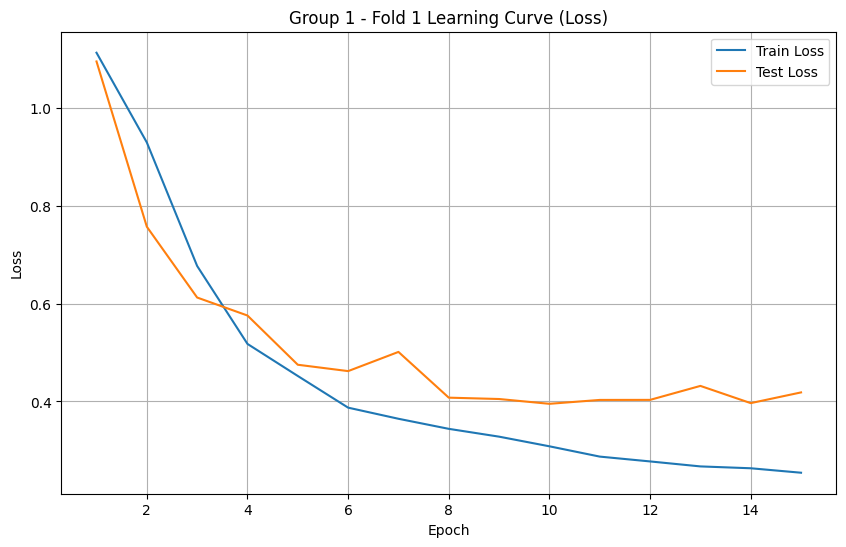

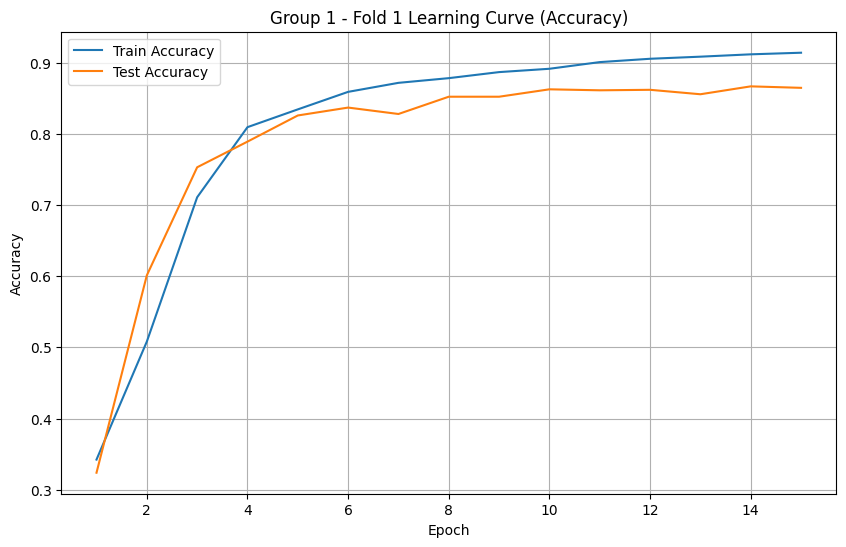

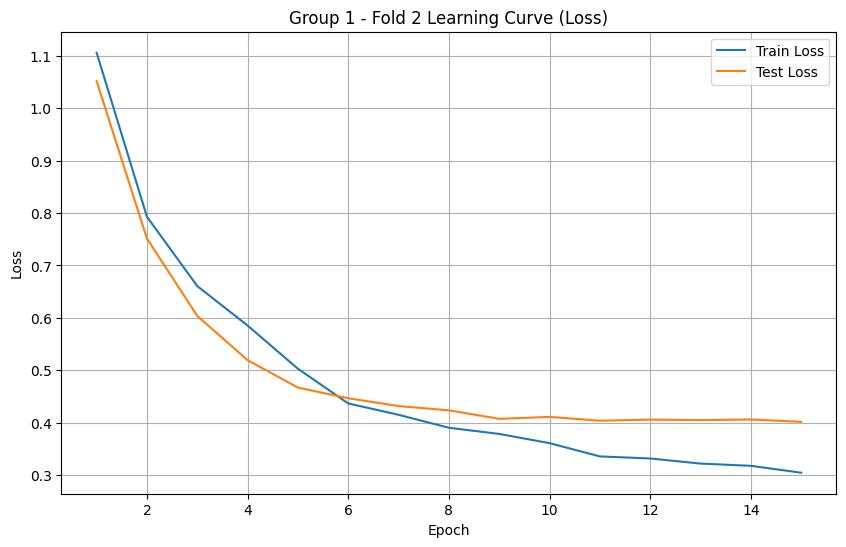

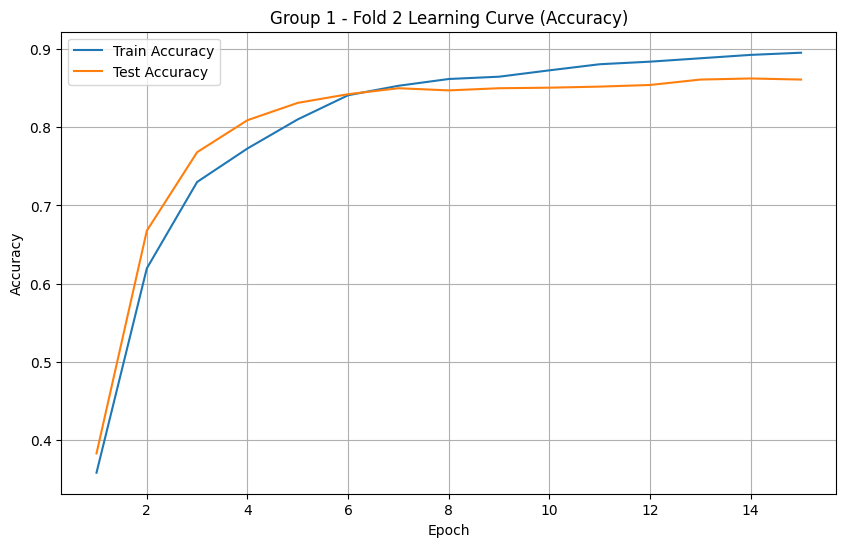

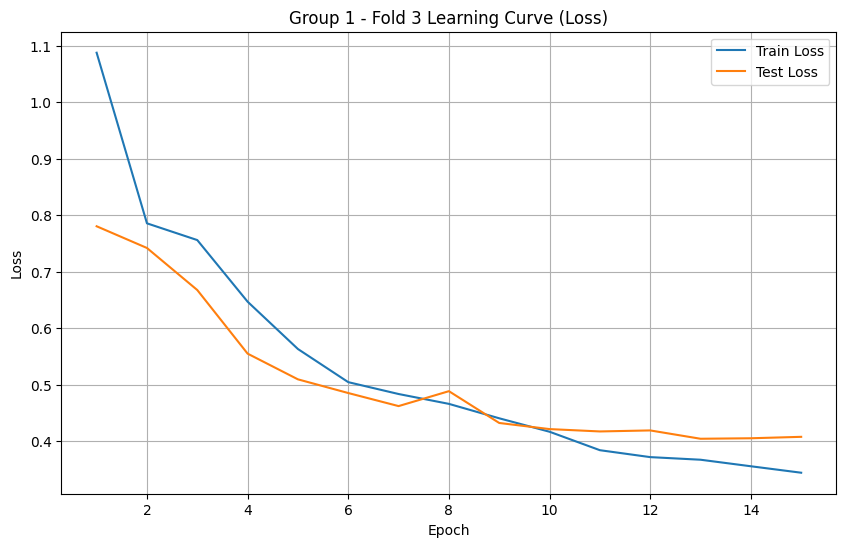

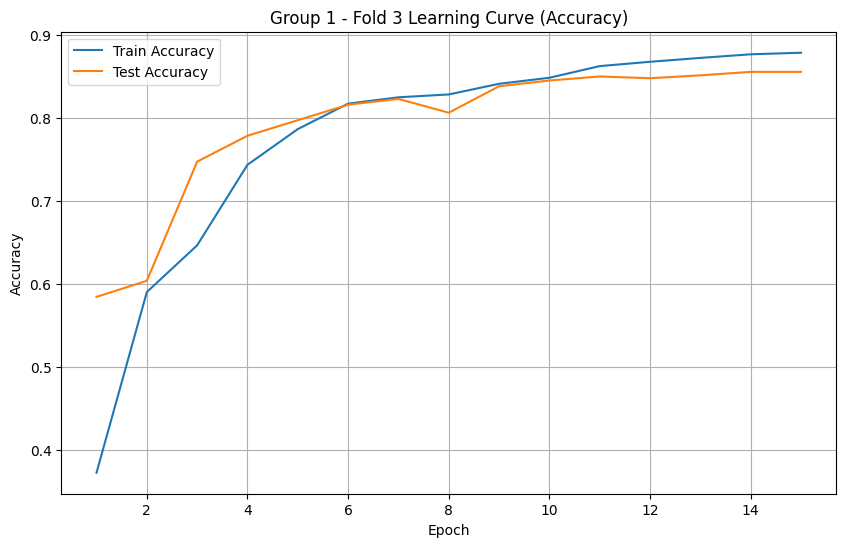

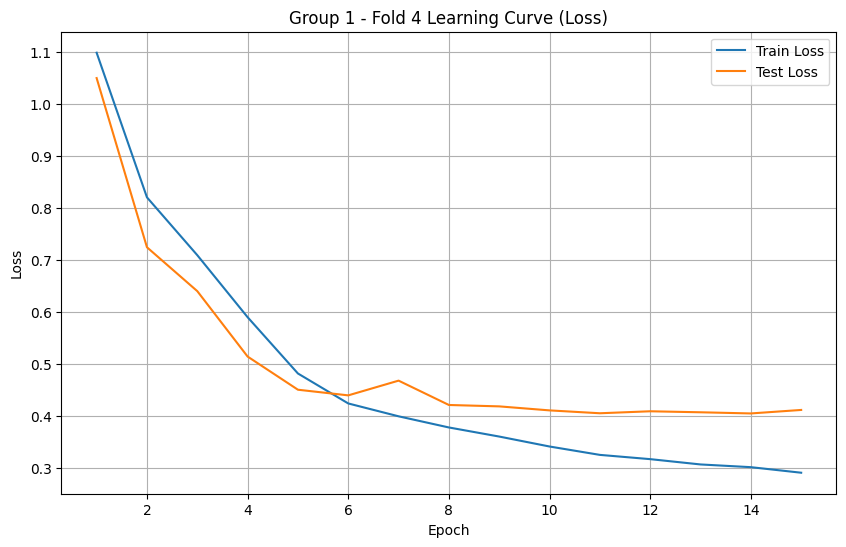

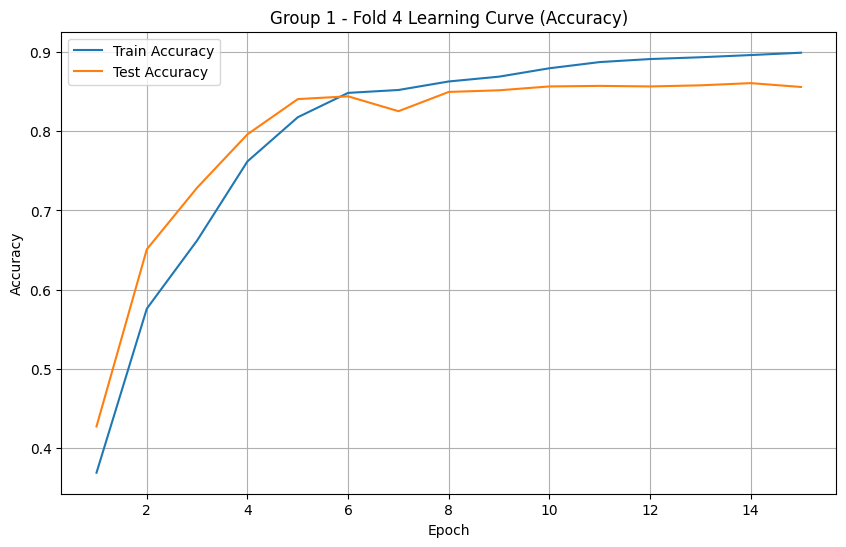

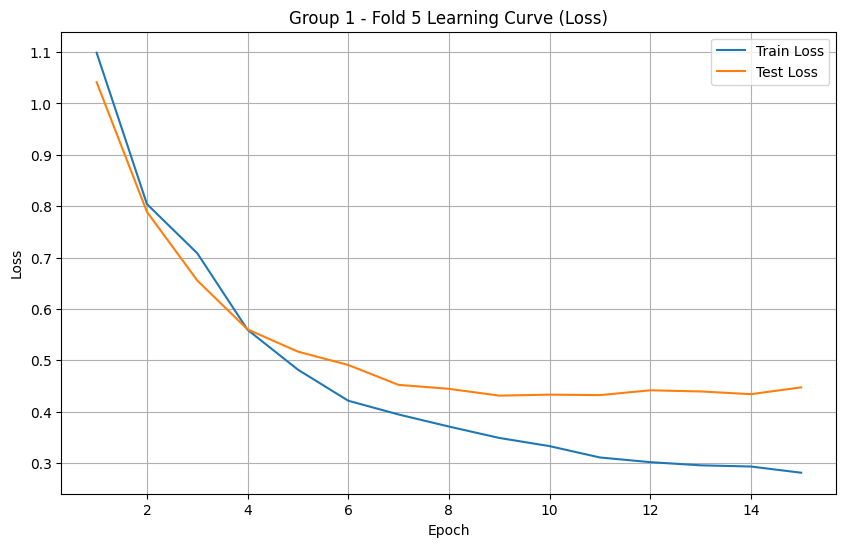

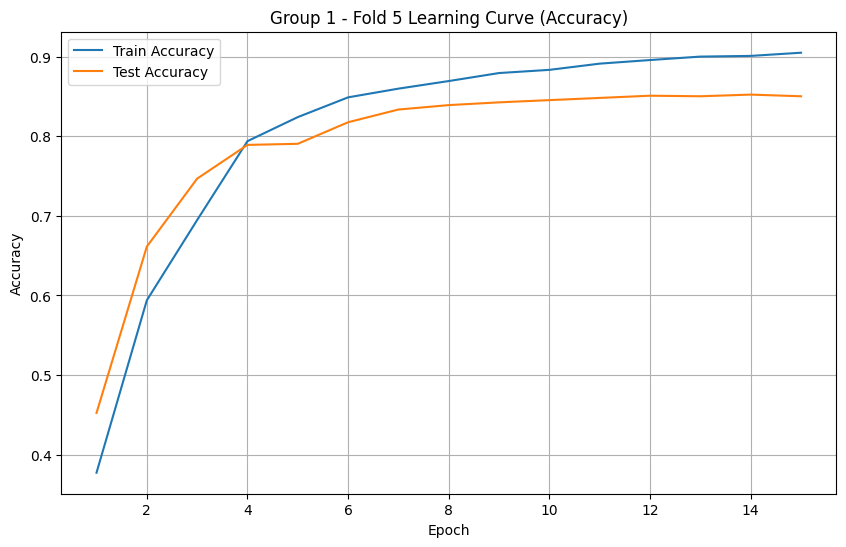

Confusion Matrix for Fold 1 is invalid or missing.


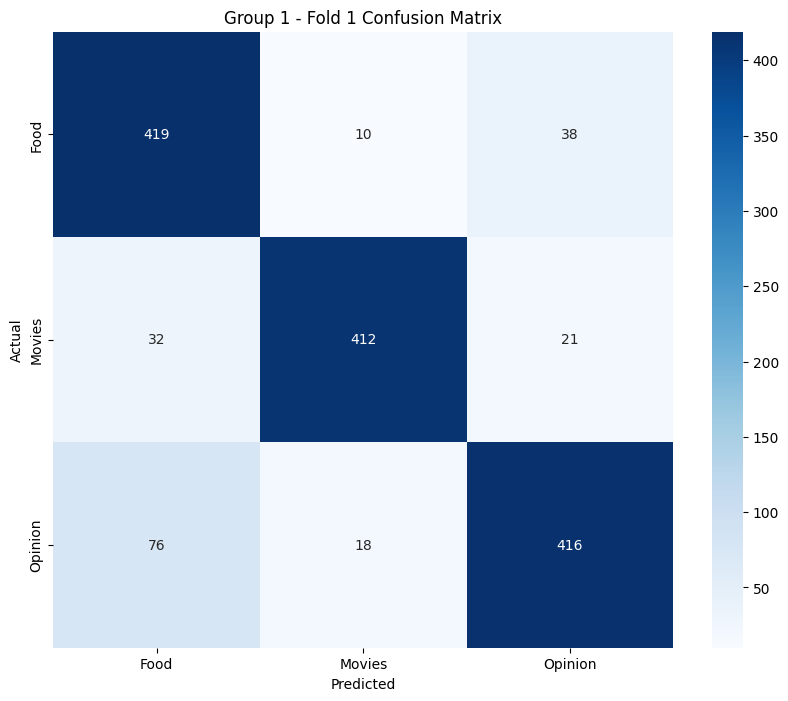

Confusion Matrix for Fold 2 is invalid or missing.


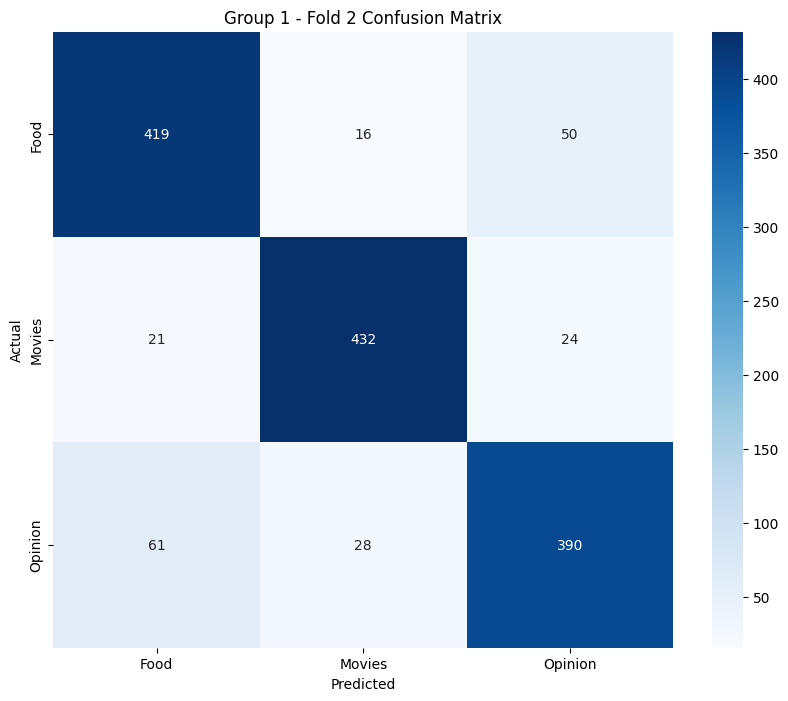

Confusion Matrix for Fold 3 is invalid or missing.


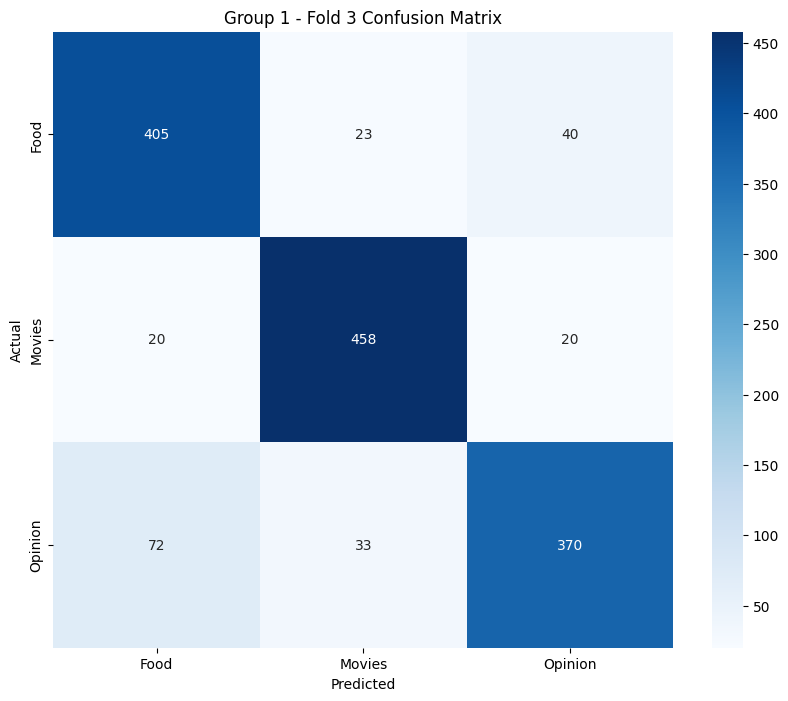

Confusion Matrix for Fold 4 is invalid or missing.


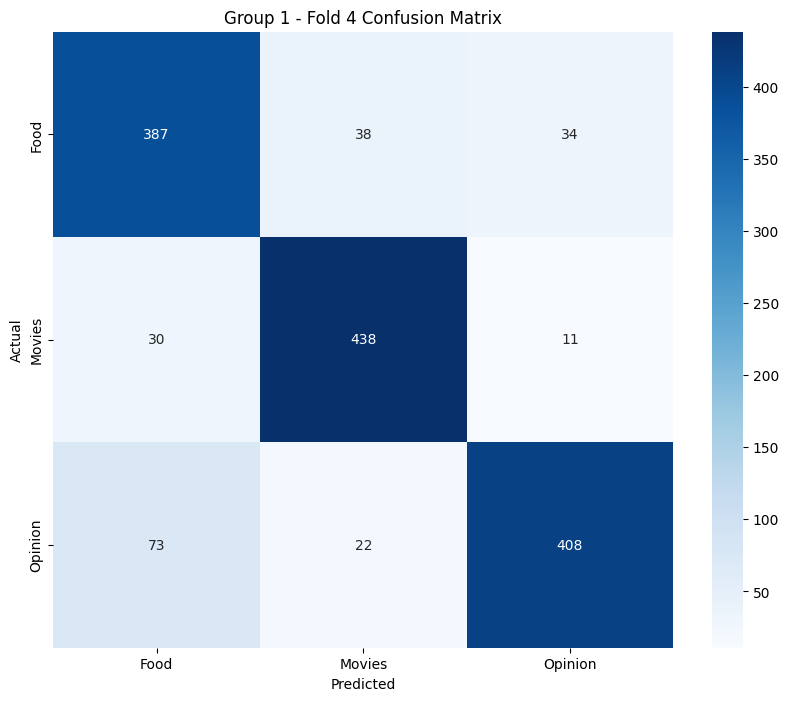

Confusion Matrix for Fold 5 is invalid or missing.


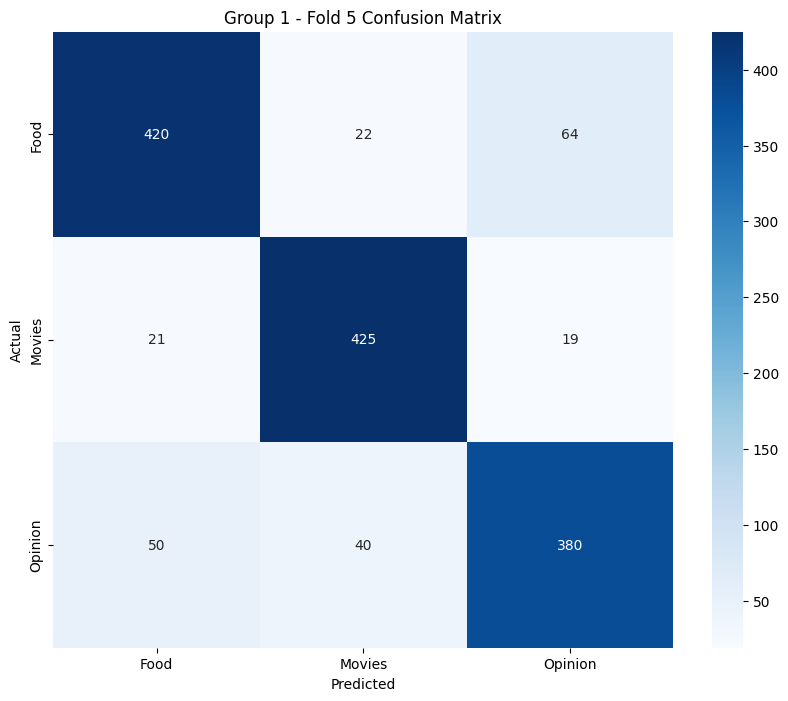


Group 2 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.0960, Test Accuracy: 0.3463
epoch 1/15: train loss 1.0740, train acc 0.4132
                         test loss 1.0413, test acc 0.4365
epoch 5/15: train loss 0.7336, train acc 0.7001
                         test loss 0.6469, test acc 0.7370
epoch 10/15: train loss 0.5016, train acc 0.8028
                         test loss 0.5452, test acc 0.7752
epoch 15/15: train loss 0.4242, train acc 0.8365
                         test loss 0.5374, test acc 0.7793

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1277, Test Accuracy: 0.3296
epoch 1/15: train loss 1.0710, train acc 0.4033
                         test loss 1.0646, test acc 0.4254
epoch 5/15: train loss 0.7242, train acc 0.7003
                         test loss 0.7297, test acc 0.6891
epoch 10/15: train loss 0.5405, train acc 0.7883
                         test loss 0.6302, test acc 0.7432
epoch 15/15: train loss 0.4705, train acc 0.8181
                         t

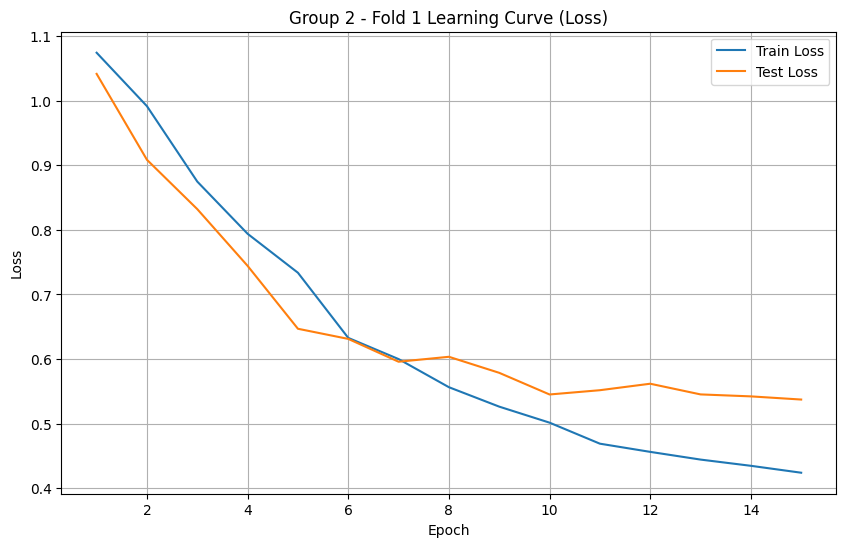

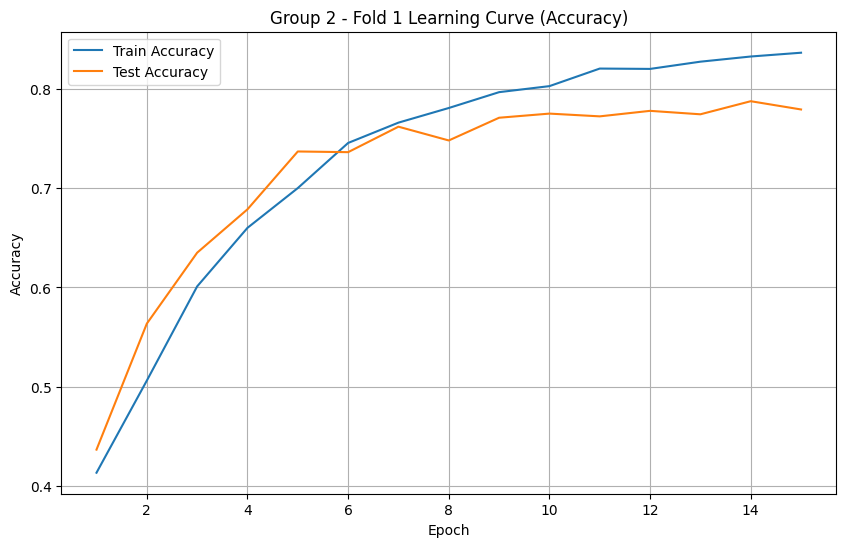

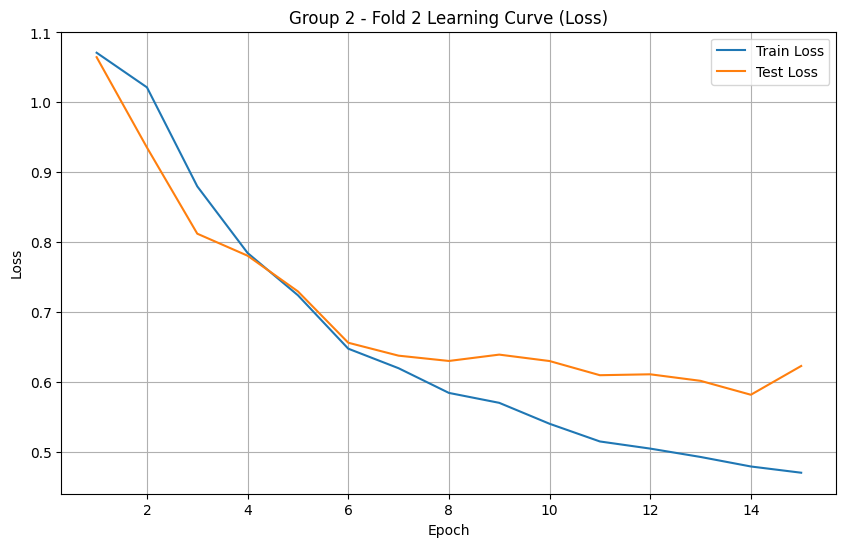

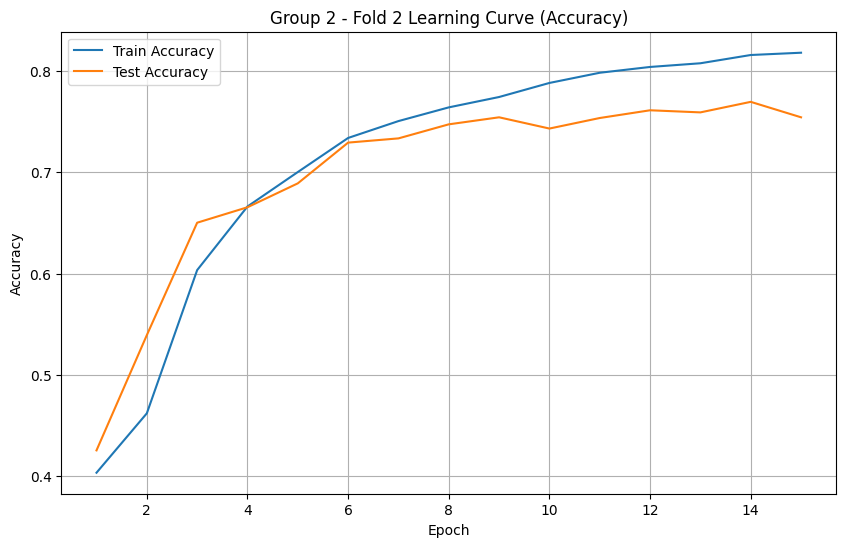

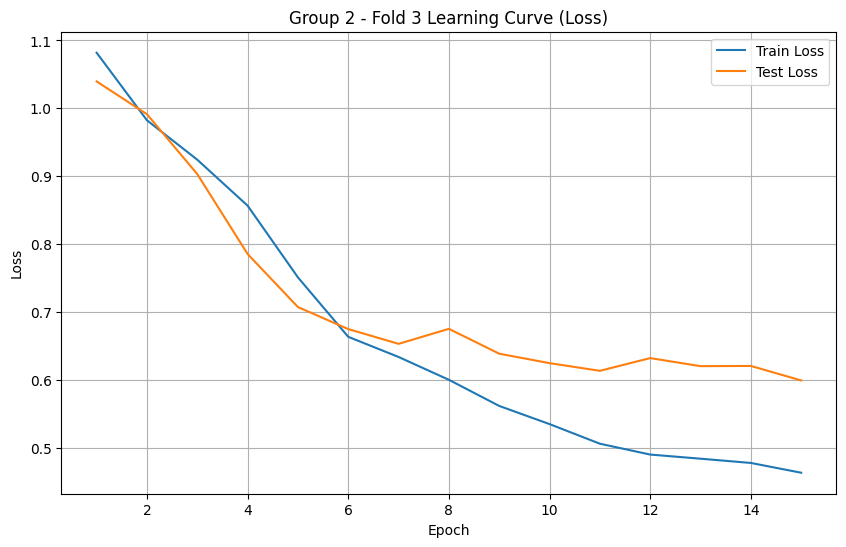

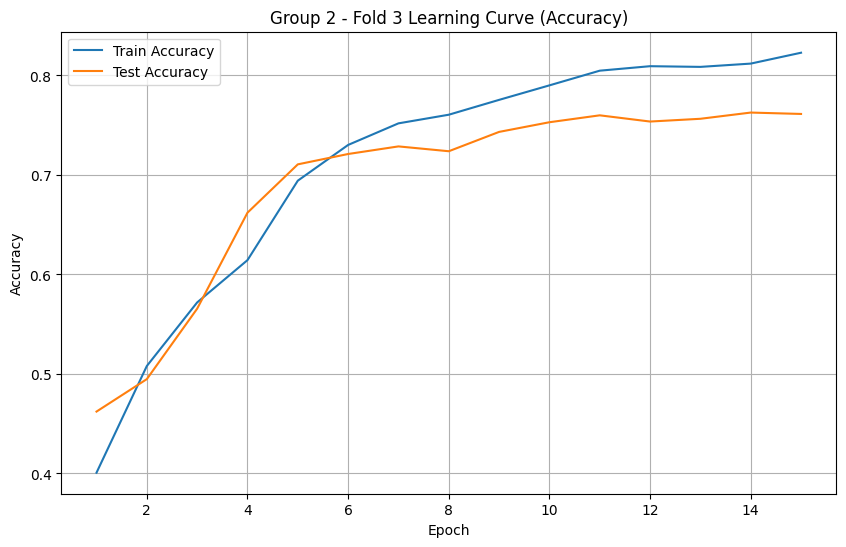

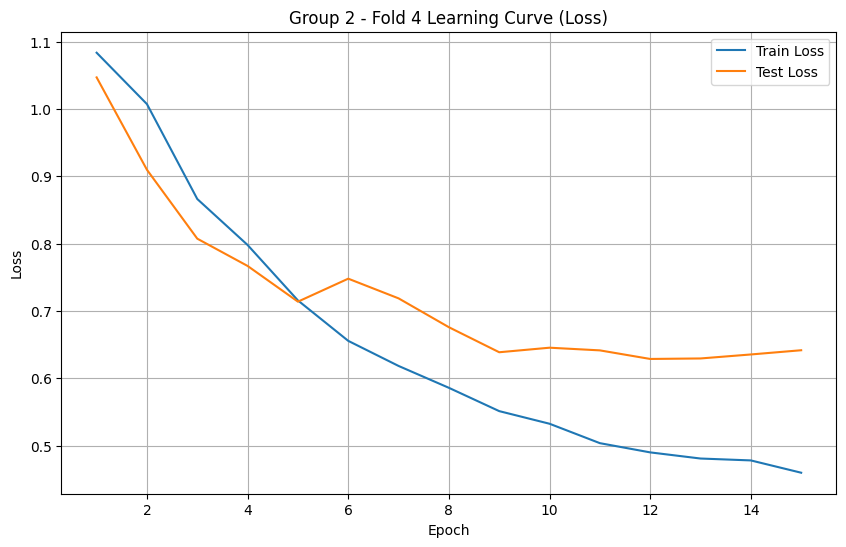

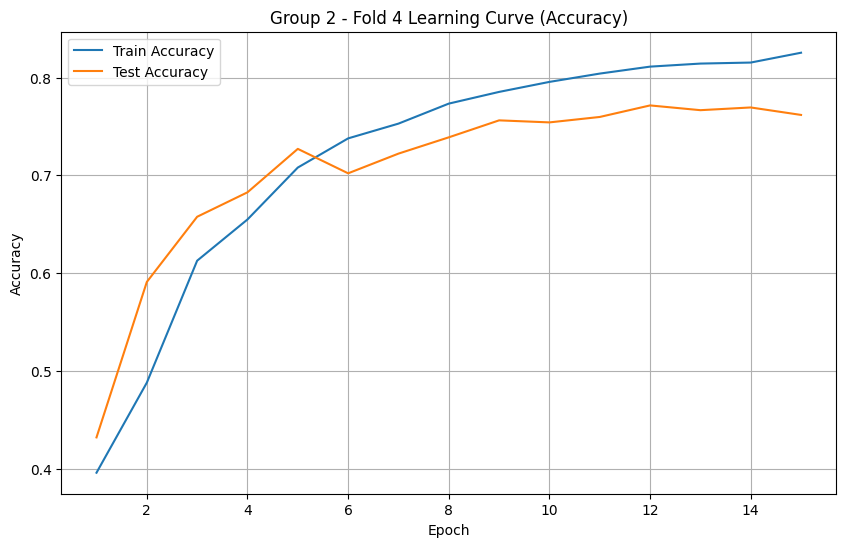

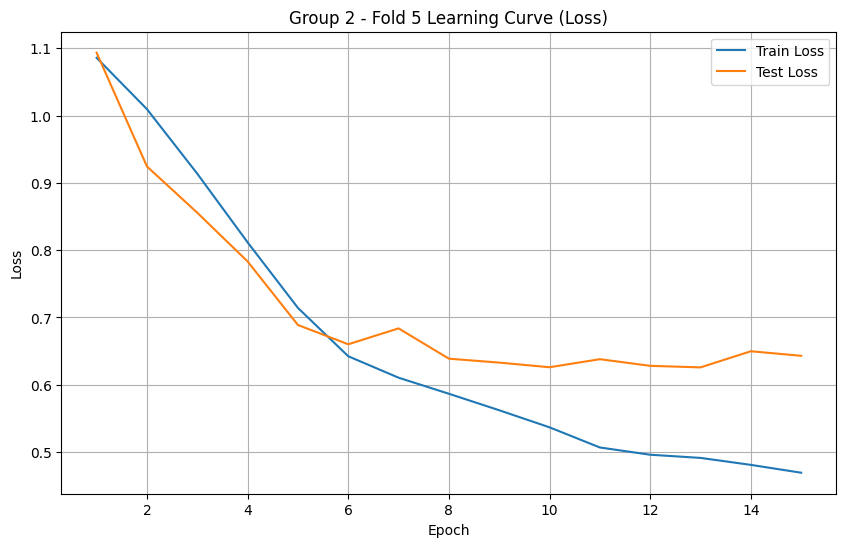

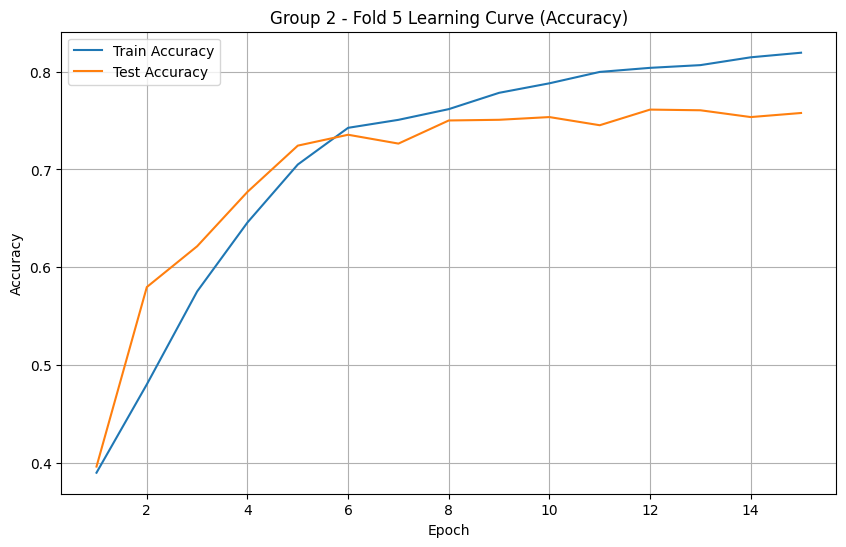

Confusion Matrix for Fold 1 is invalid or missing.


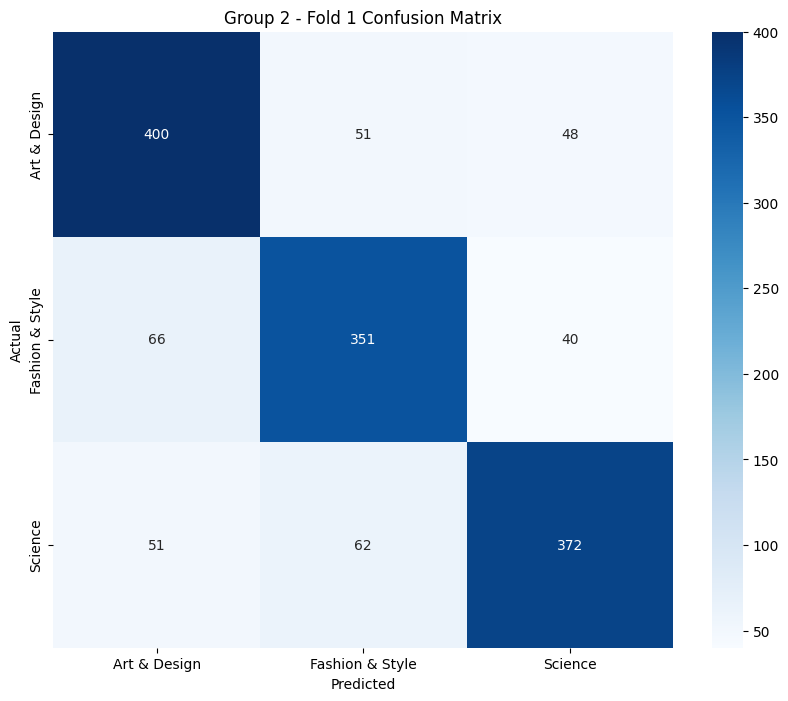

Confusion Matrix for Fold 2 is invalid or missing.


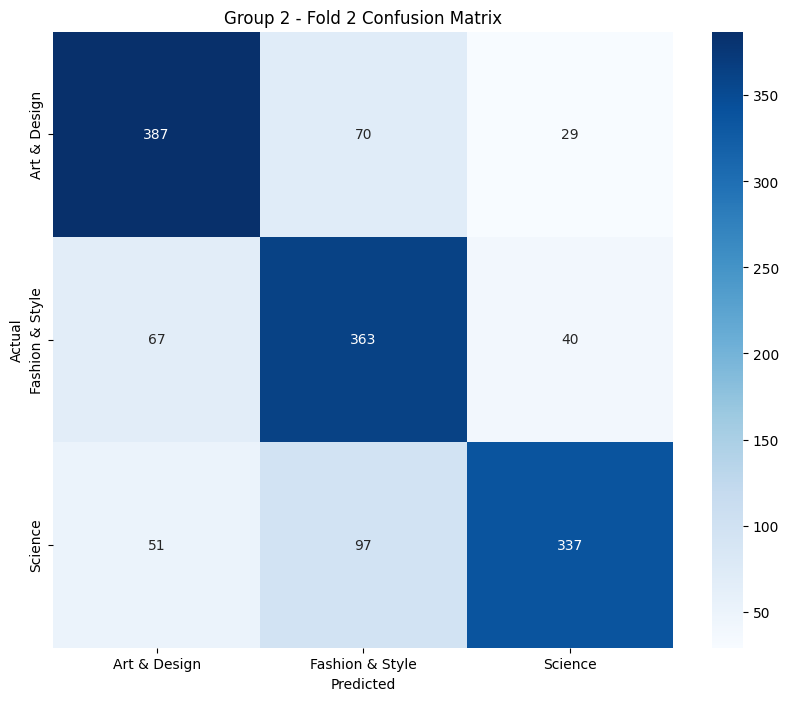

Confusion Matrix for Fold 3 is invalid or missing.


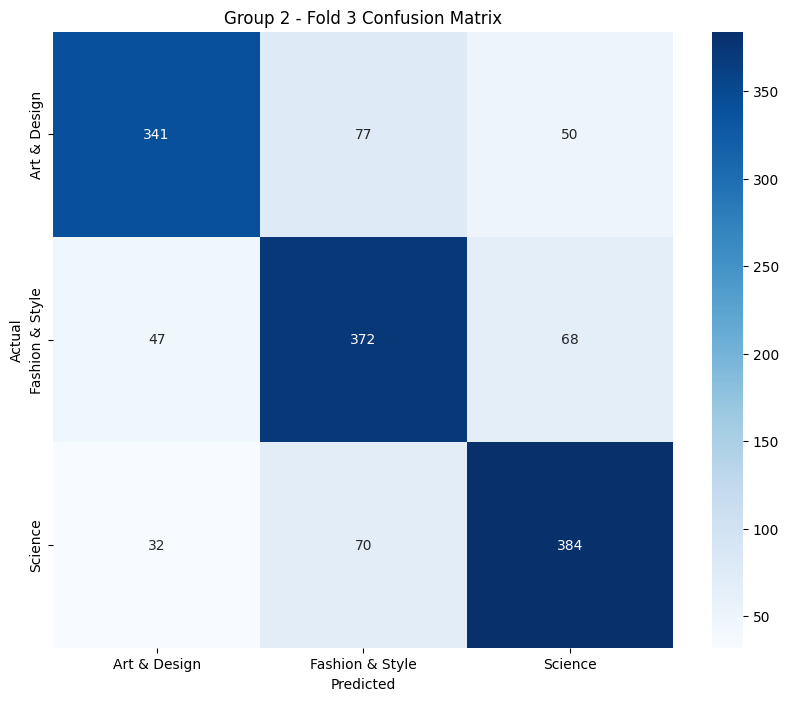

Confusion Matrix for Fold 4 is invalid or missing.


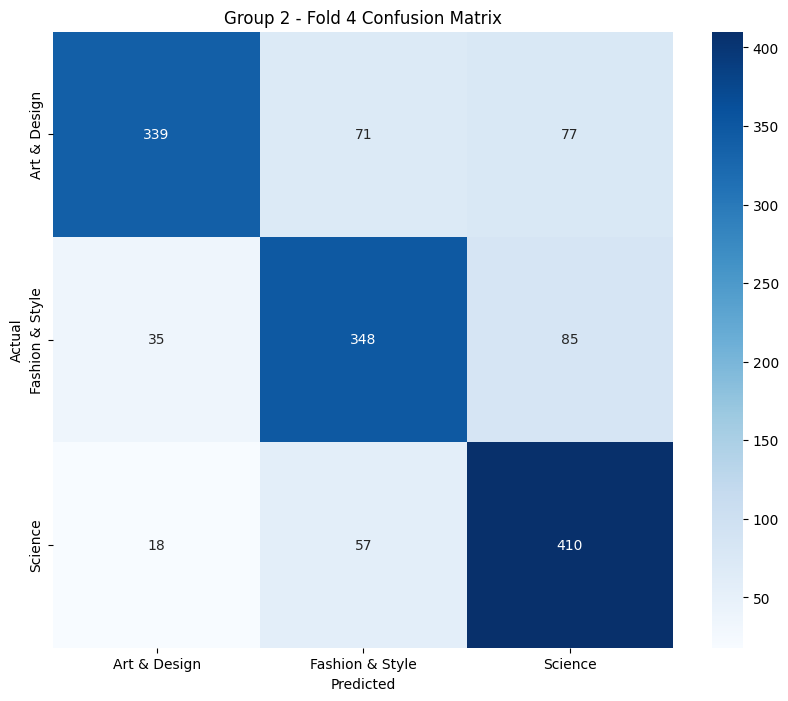

Confusion Matrix for Fold 5 is invalid or missing.


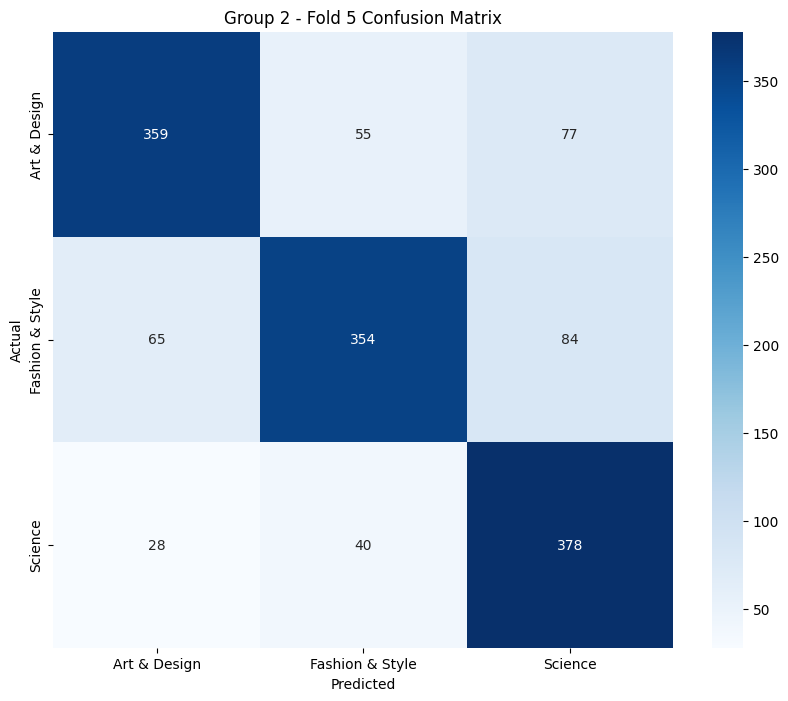


Group 3 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1014, Test Accuracy: 0.3527
epoch 1/15: train loss 1.0974, train acc 0.3738
                         test loss 1.1074, test acc 0.3254
epoch 5/15: train loss 0.6283, train acc 0.7528
                         test loss 0.6014, test acc 0.7749
epoch 10/15: train loss 0.4775, train acc 0.8216
                         test loss 0.5325, test acc 0.8022
epoch 15/15: train loss 0.4155, train acc 0.8467
                         test loss 0.4744, test acc 0.8158

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1774, Test Accuracy: 0.3384
epoch 1/15: train loss 1.0900, train acc 0.3743
                         test loss 0.9665, test acc 0.5183
epoch 5/15: train loss 0.6029, train acc 0.7635
                         test loss 0.6142, test acc 0.7642
epoch 10/15: train loss 0.4418, train acc 0.8367
                         test loss 0.5849, test acc 0.7928
epoch 15/15: train loss 0.3845, train acc 0.8555
                         t

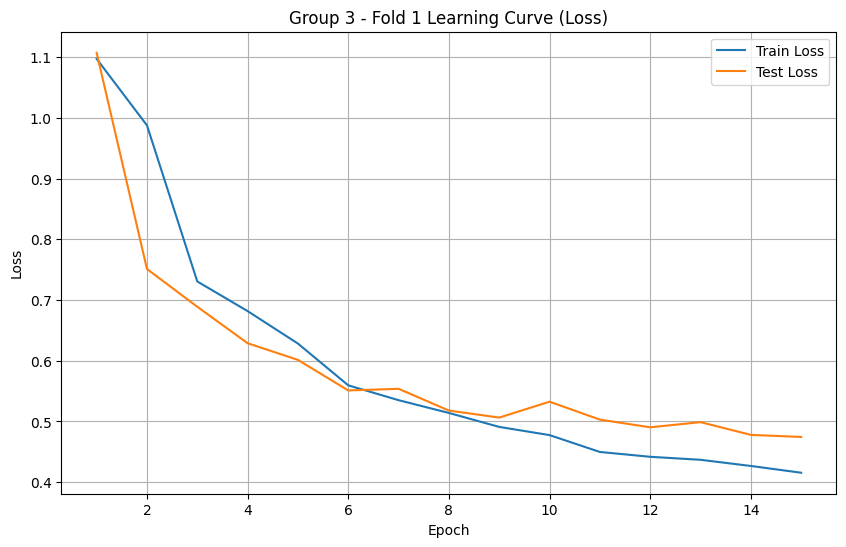

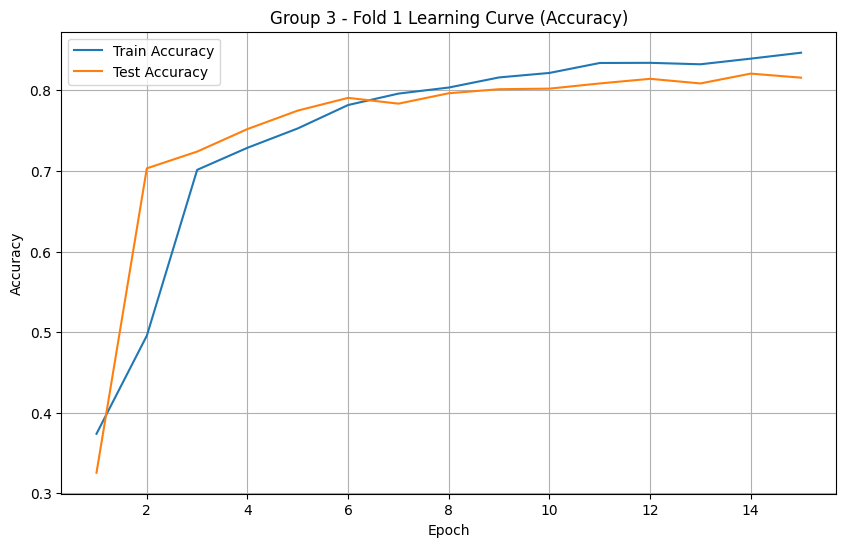

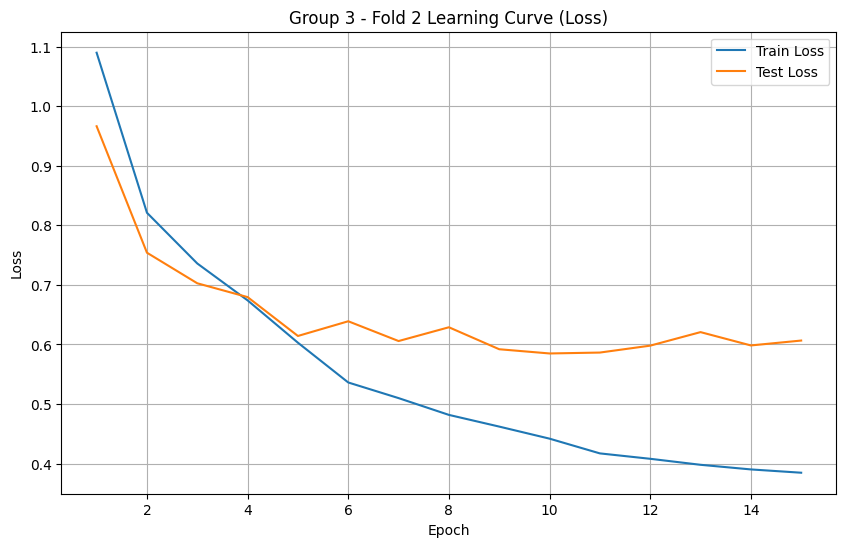

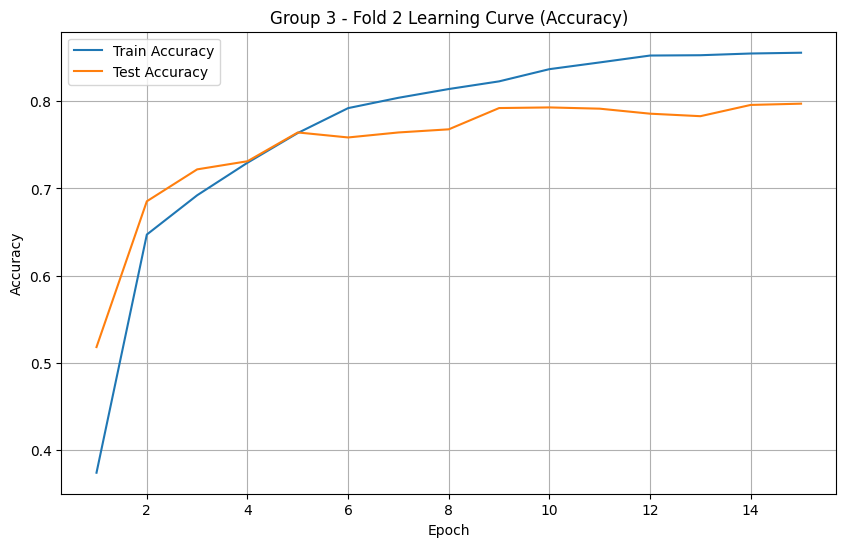

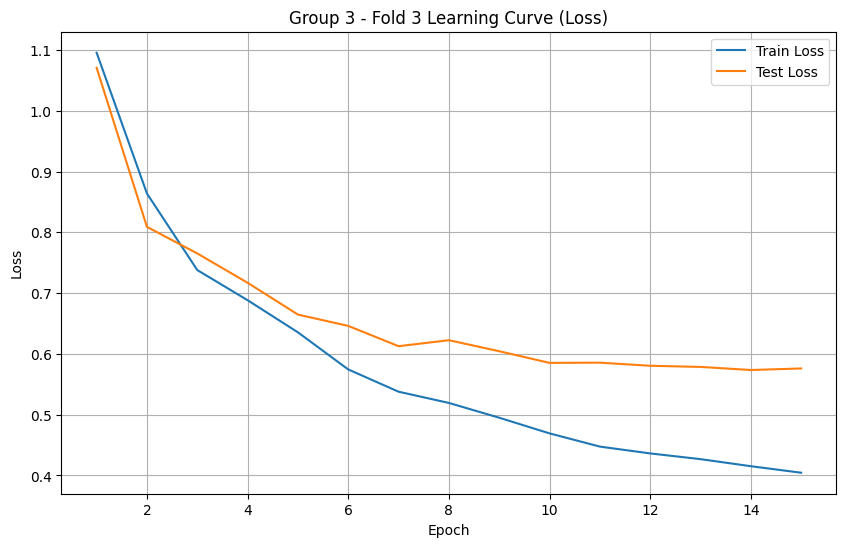

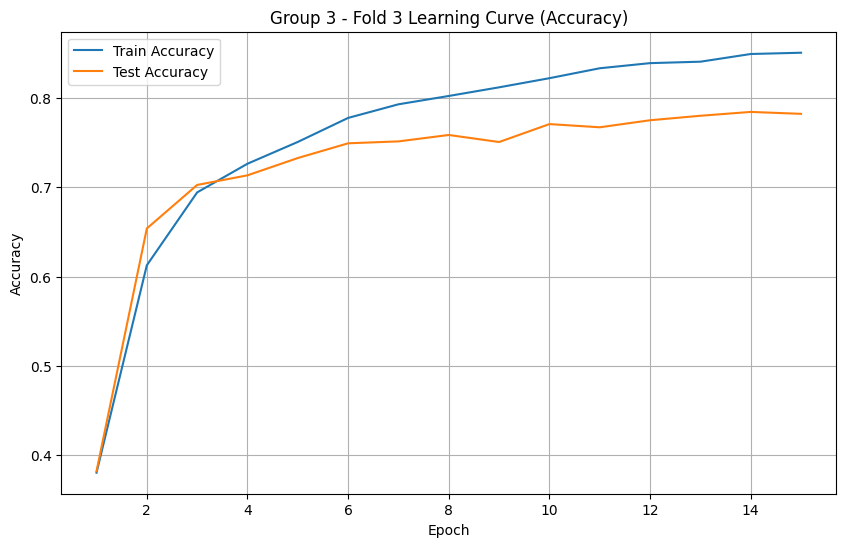

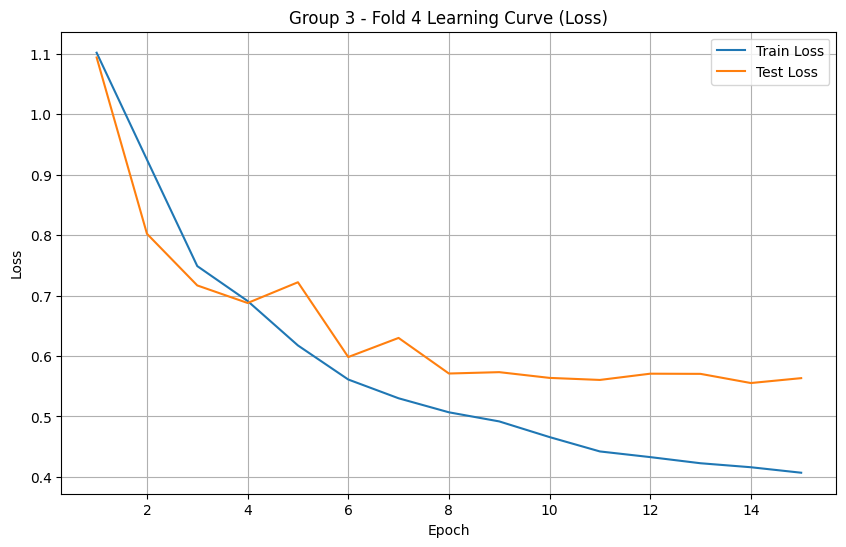

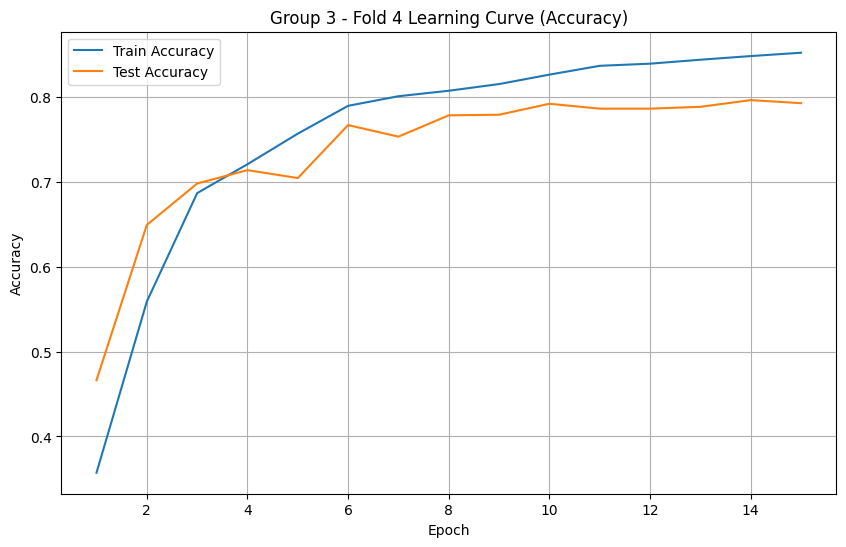

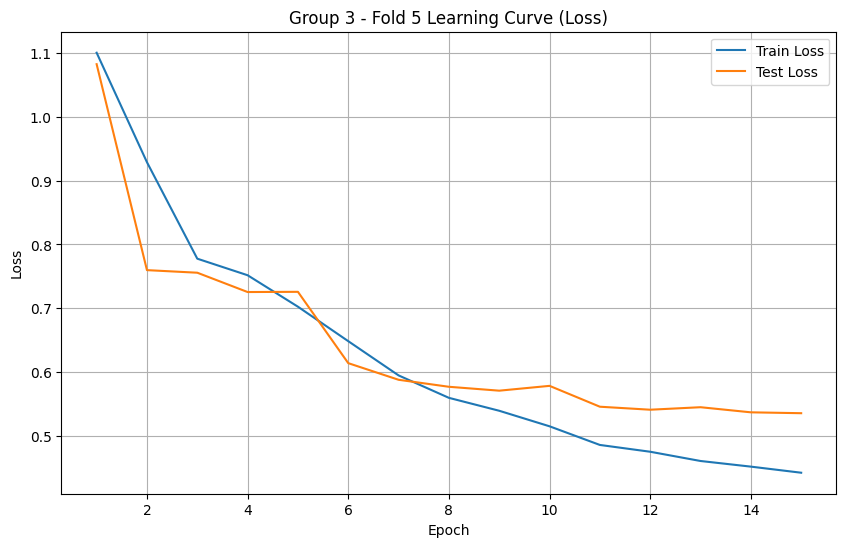

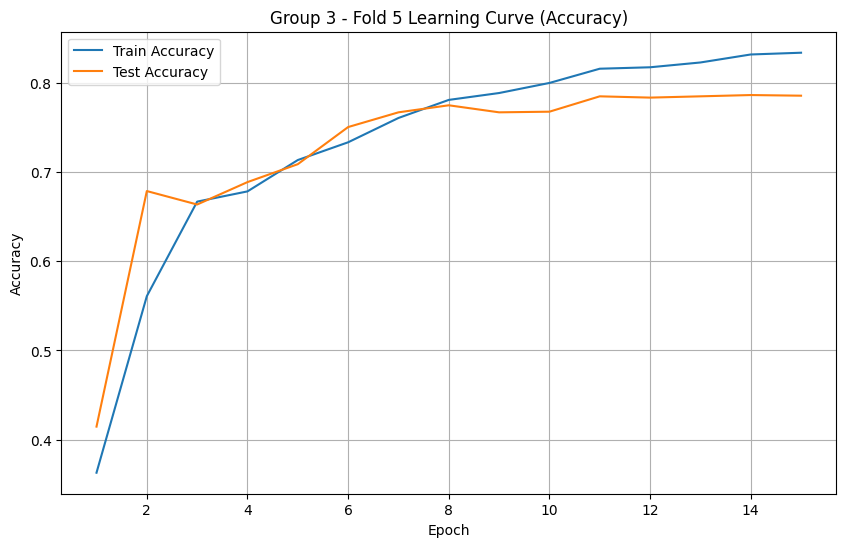

Confusion Matrix for Fold 1 is invalid or missing.


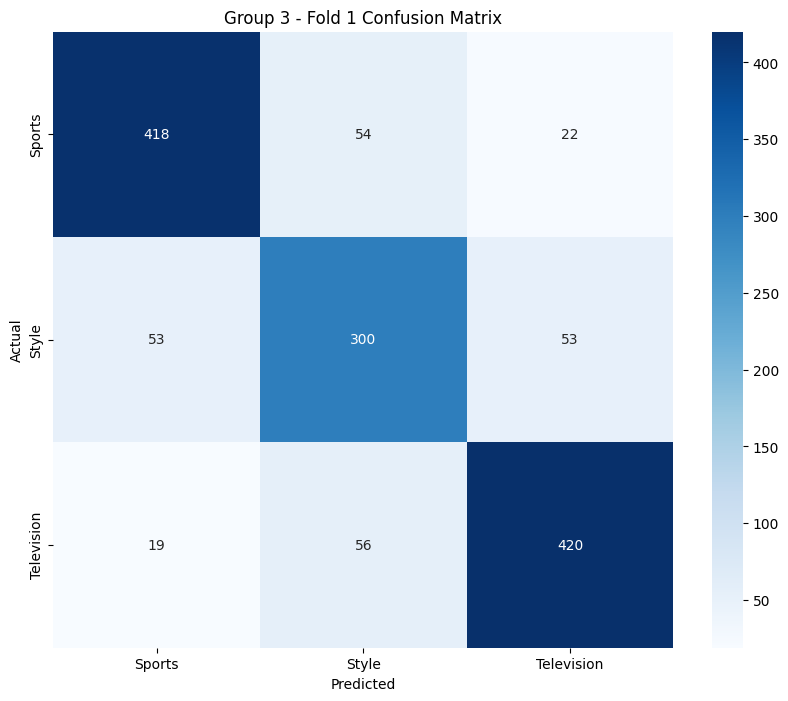

Confusion Matrix for Fold 2 is invalid or missing.


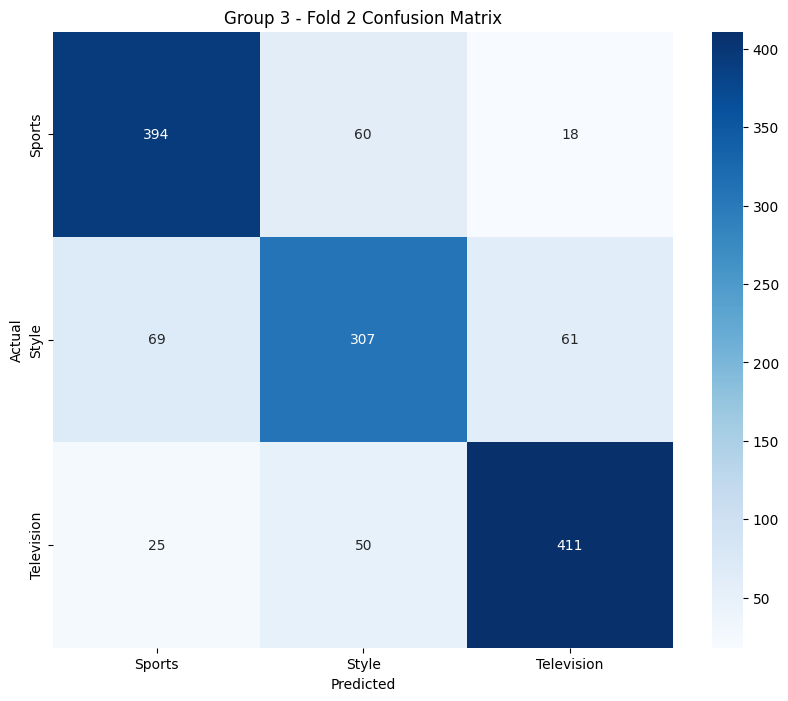

Confusion Matrix for Fold 3 is invalid or missing.


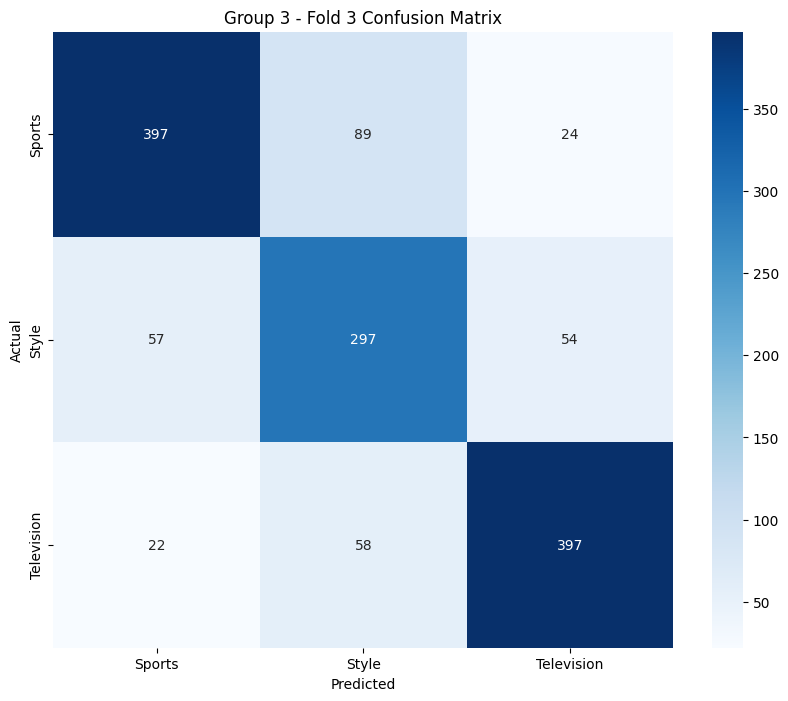

Confusion Matrix for Fold 4 is invalid or missing.


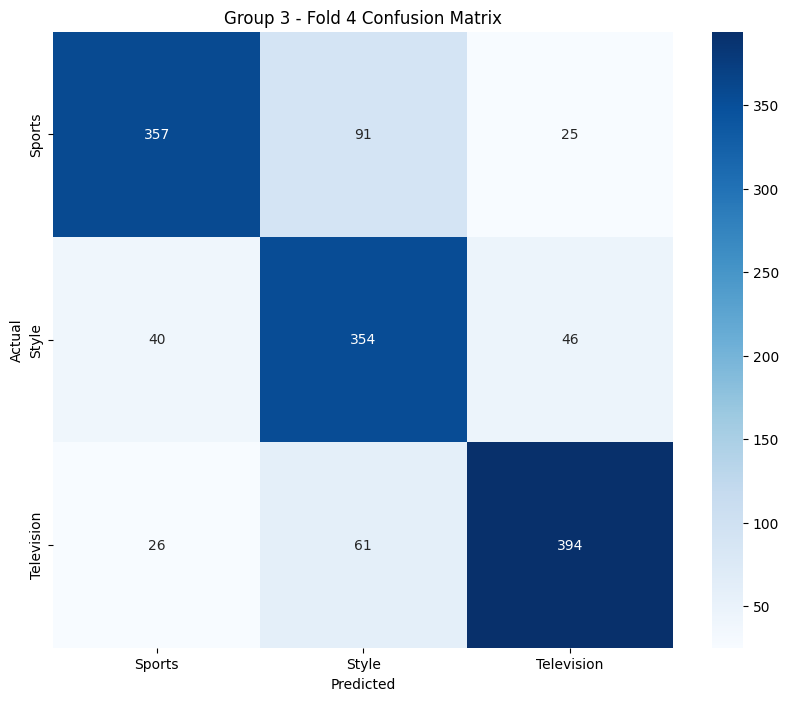

Confusion Matrix for Fold 5 is invalid or missing.


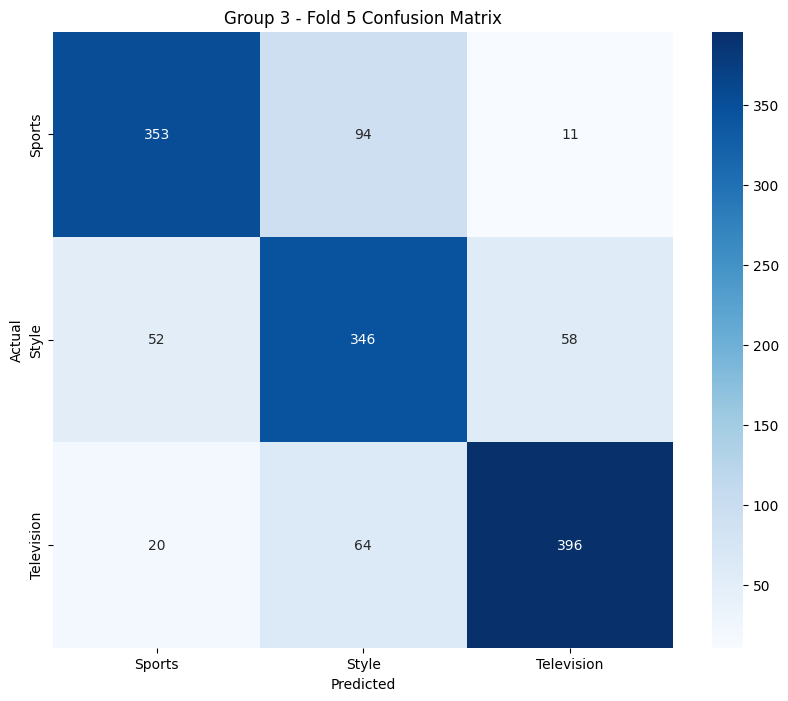


Group 4 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1422, Test Accuracy: 0.3408
epoch 1/15: train loss 1.1063, train acc 0.3461
                         test loss 1.0936, test acc 0.3338
epoch 5/15: train loss 0.4845, train acc 0.7949
                         test loss 0.4650, test acc 0.8011
epoch 10/15: train loss 0.3218, train acc 0.8710
                         test loss 0.3900, test acc 0.8540
epoch 15/15: train loss 0.2679, train acc 0.8985
                         test loss 0.4040, test acc 0.8470

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1167, Test Accuracy: 0.3122
epoch 1/15: train loss 1.1128, train acc 0.3354
                         test loss 1.0975, test acc 0.3679
epoch 5/15: train loss 0.5863, train acc 0.7493
                         test loss 0.5499, test acc 0.7844
epoch 10/15: train loss 0.3929, train acc 0.8444
                         test loss 0.4442, test acc 0.8199
epoch 15/15: train loss 0.3225, train acc 0.8741
                         t

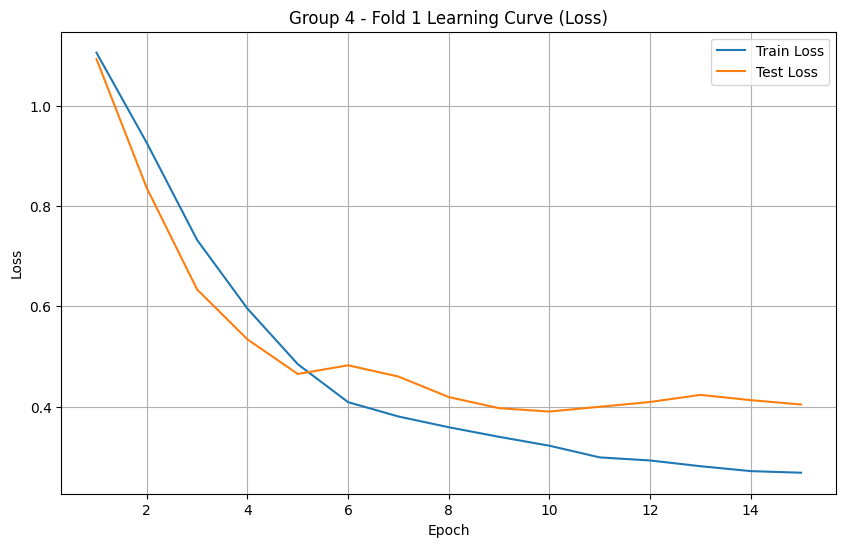

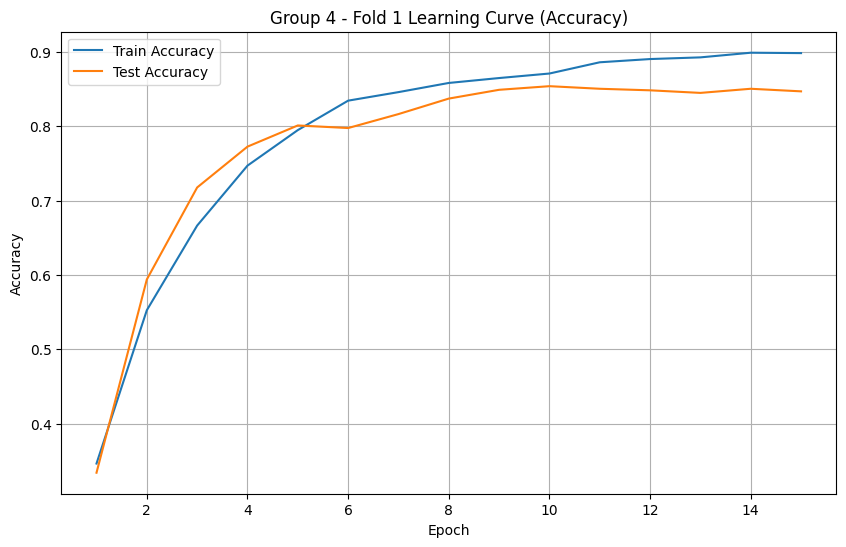

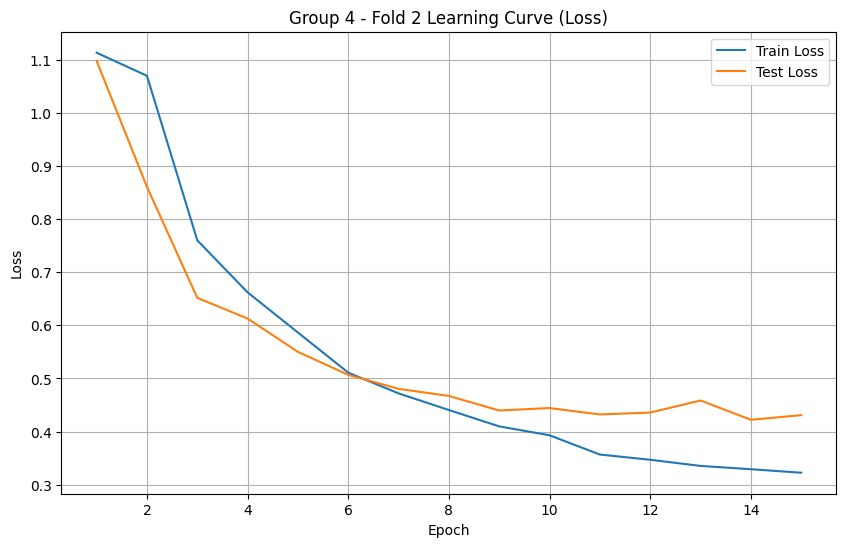

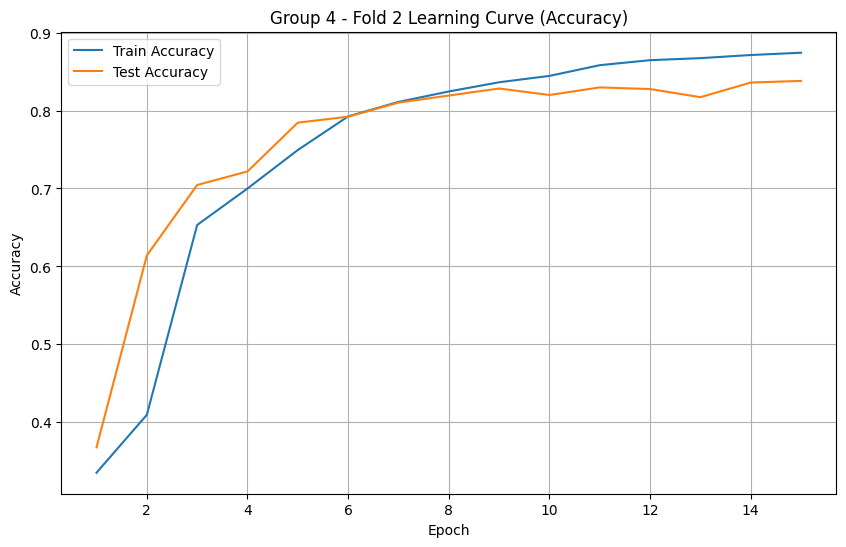

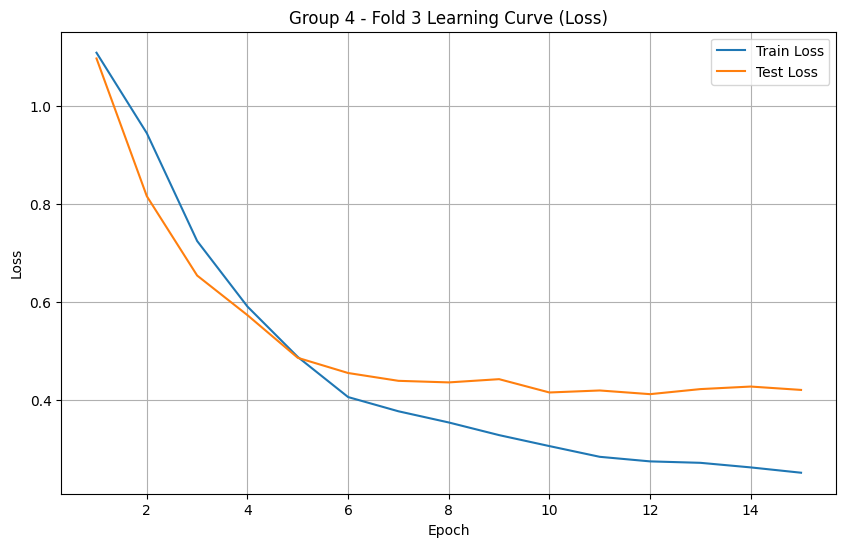

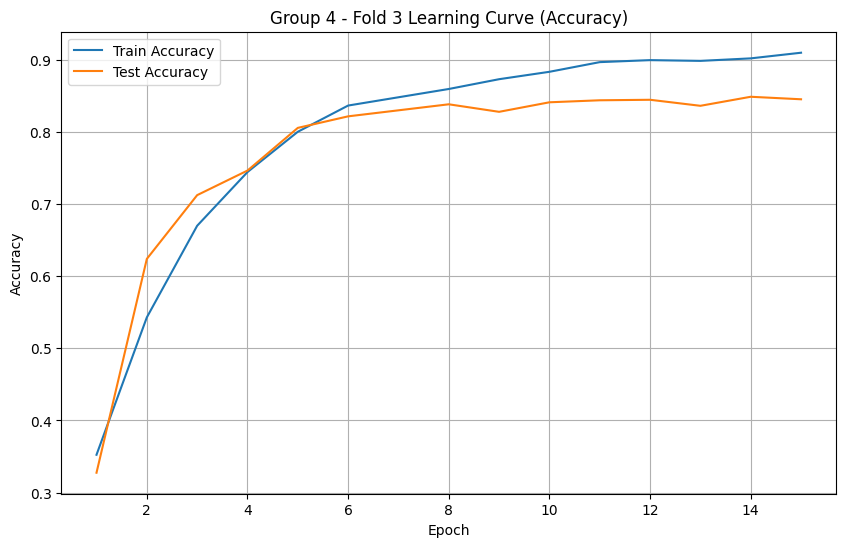

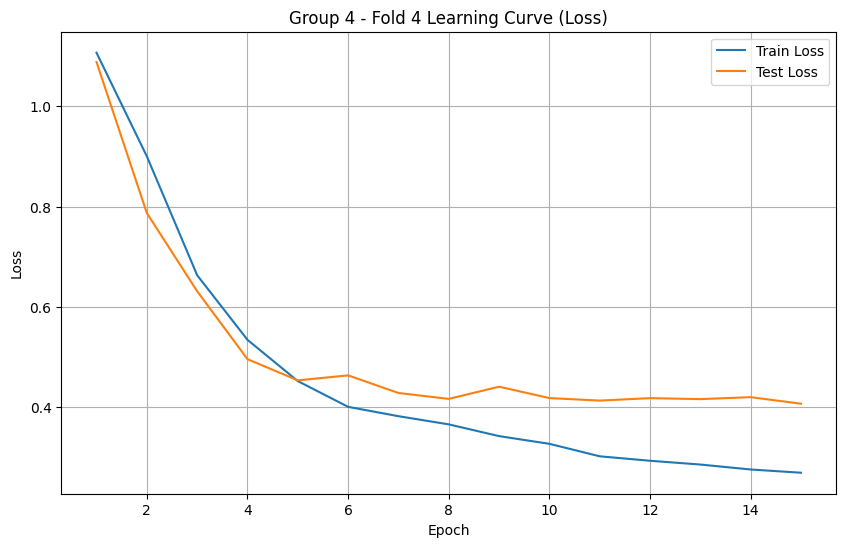

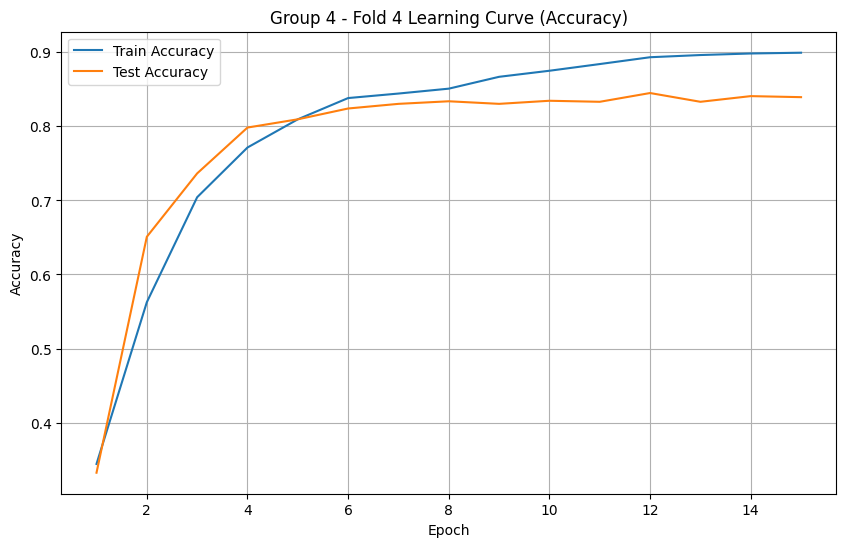

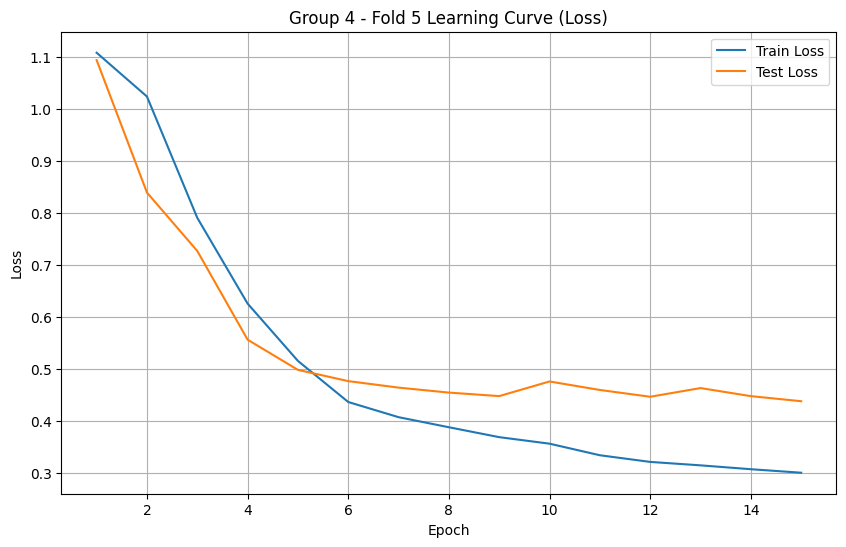

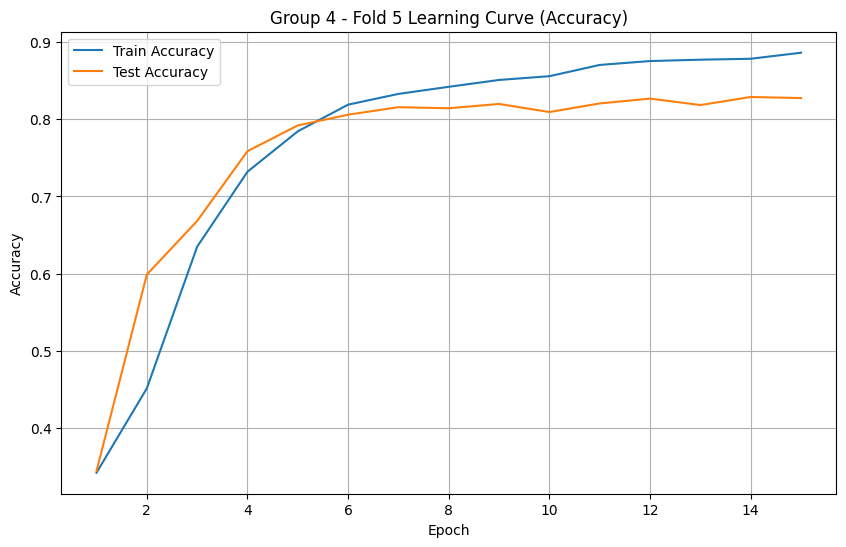

Confusion Matrix for Fold 1 is invalid or missing.


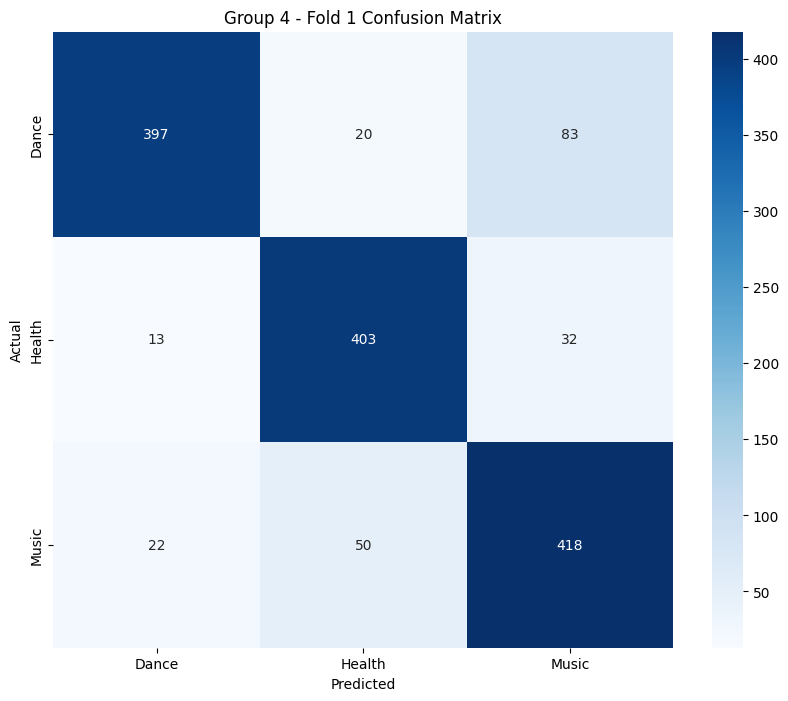

Confusion Matrix for Fold 2 is invalid or missing.


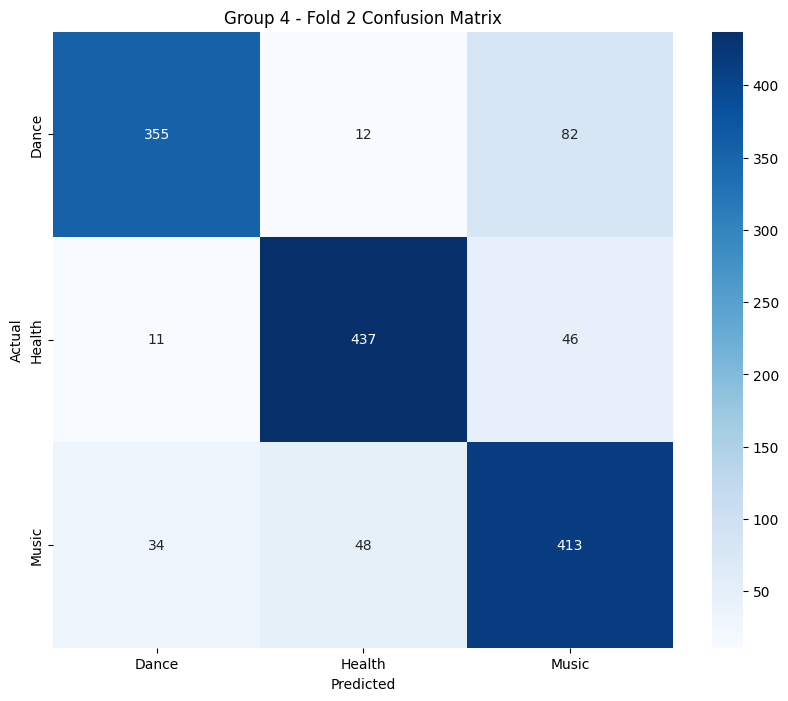

Confusion Matrix for Fold 3 is invalid or missing.


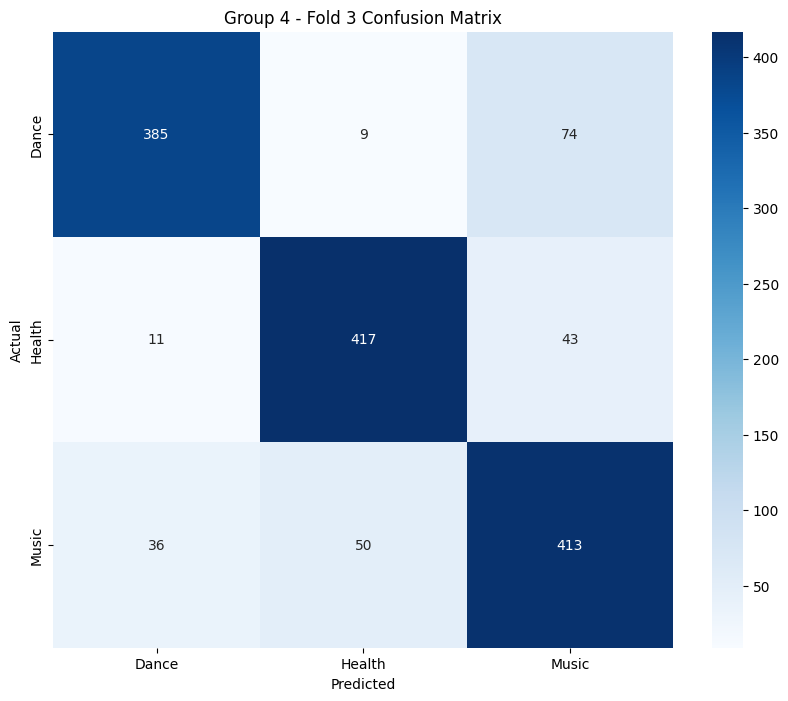

Confusion Matrix for Fold 4 is invalid or missing.


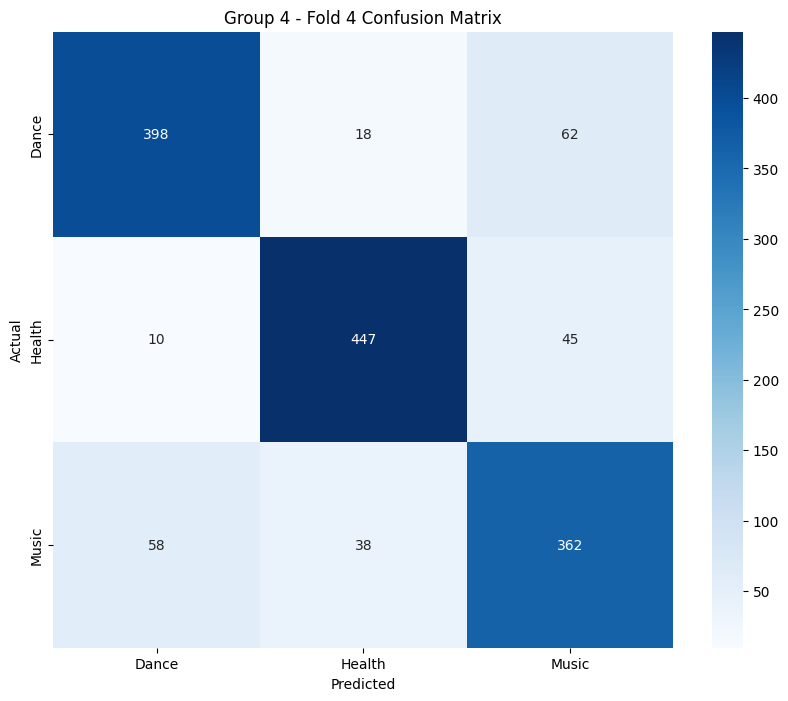

Confusion Matrix for Fold 5 is invalid or missing.


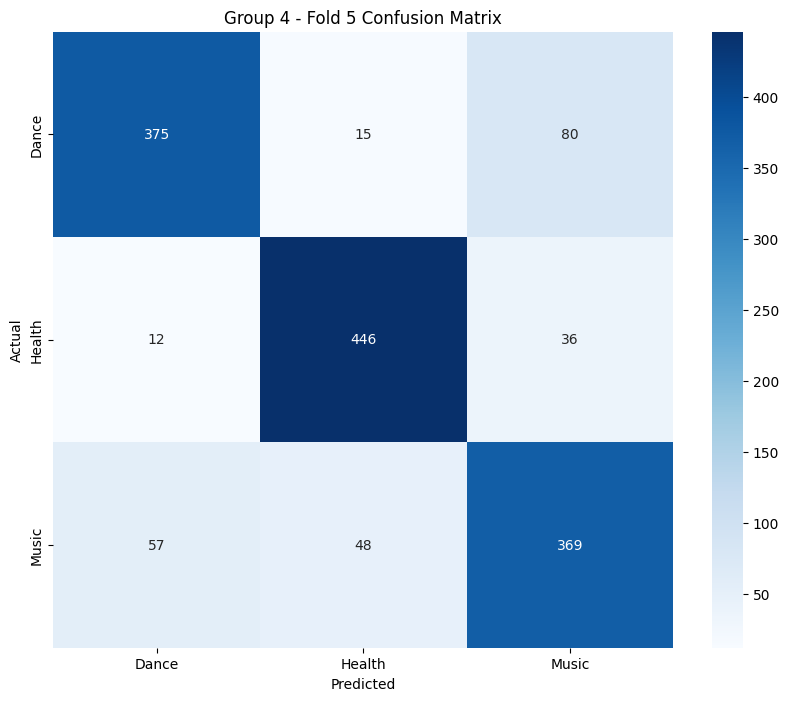


Group 5 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1029, Test Accuracy: 0.3331
epoch 1/15: train loss 1.0979, train acc 0.3770
                         test loss 1.0477, test acc 0.4583
epoch 5/15: train loss 0.6784, train acc 0.7137
                         test loss 0.6409, test acc 0.7253
epoch 10/15: train loss 0.4795, train acc 0.8184
                         test loss 0.5813, test acc 0.7712
epoch 15/15: train loss 0.4112, train acc 0.8442
                         test loss 0.5766, test acc 0.7858

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1054, Test Accuracy: 0.3241
epoch 1/15: train loss 1.0998, train acc 0.3807
                         test loss 1.0532, test acc 0.4638
epoch 5/15: train loss 0.6330, train acc 0.7384
                         test loss 0.6845, test acc 0.7079
epoch 10/15: train loss 0.4972, train acc 0.8003
                         test loss 0.6687, test acc 0.7406
epoch 15/15: train loss 0.4357, train acc 0.8296
                         t

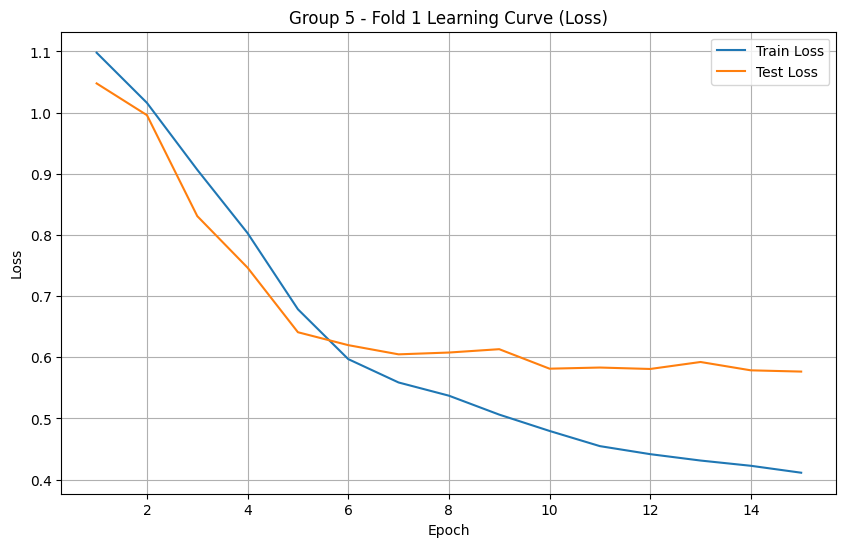

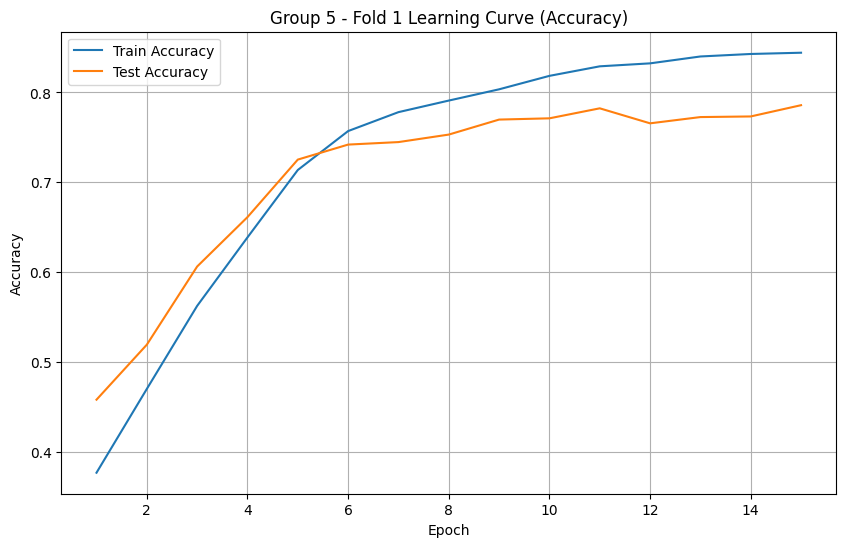

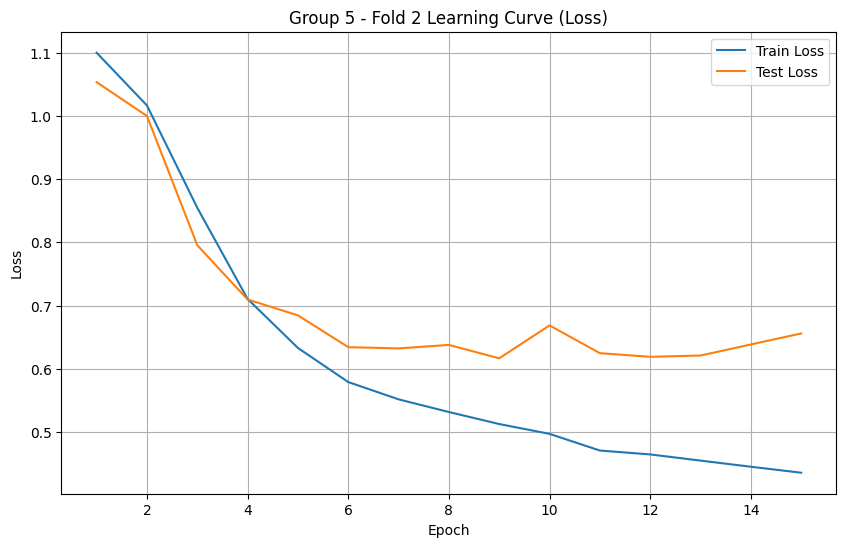

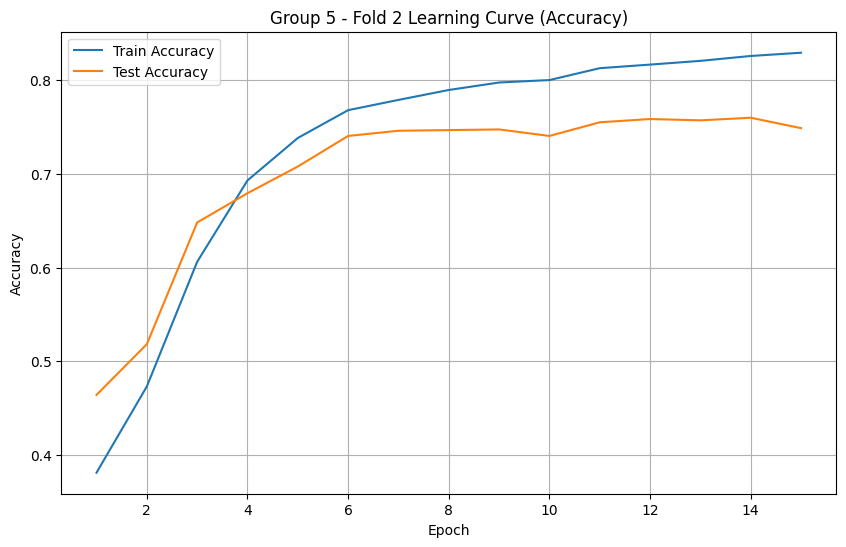

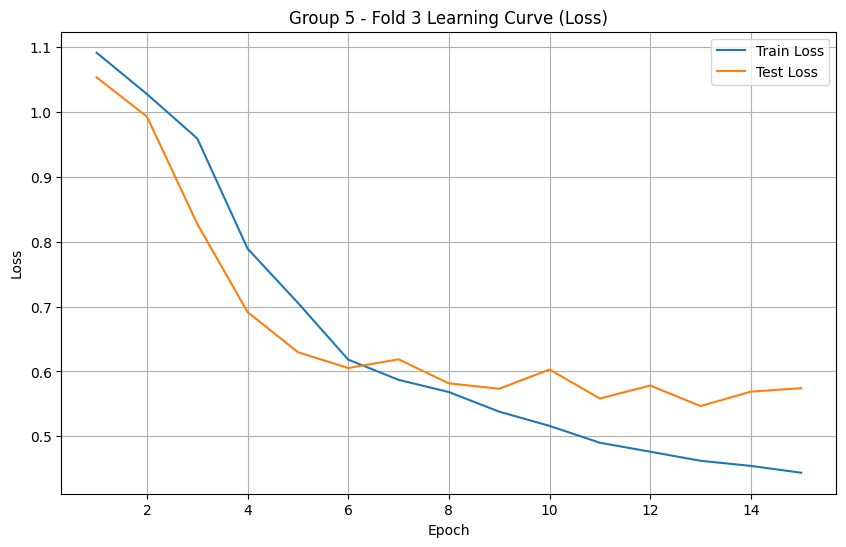

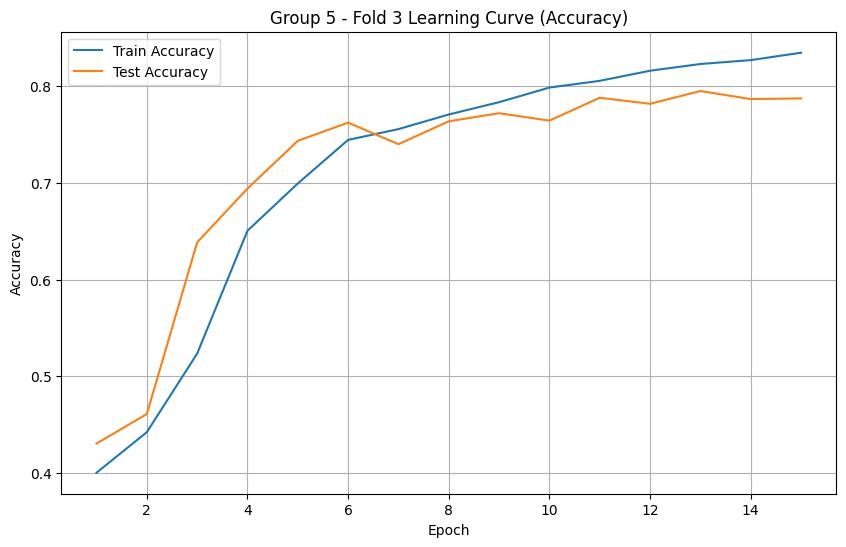

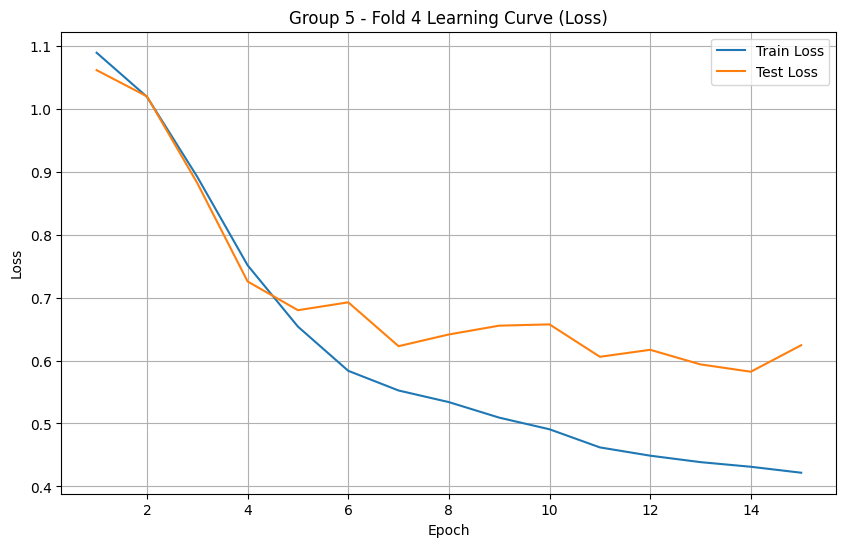

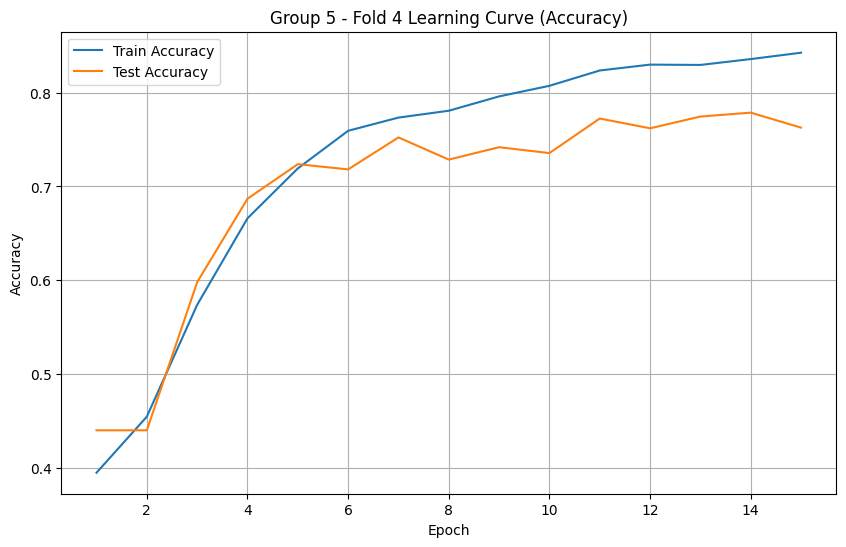

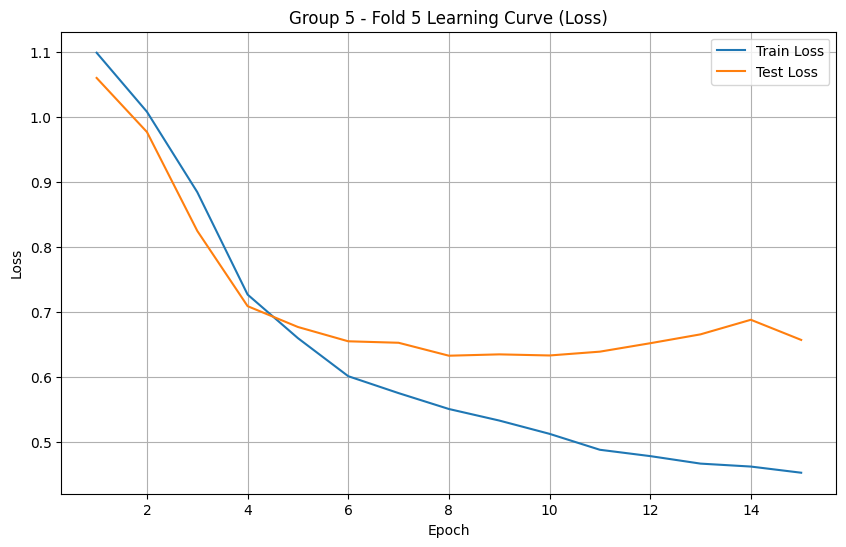

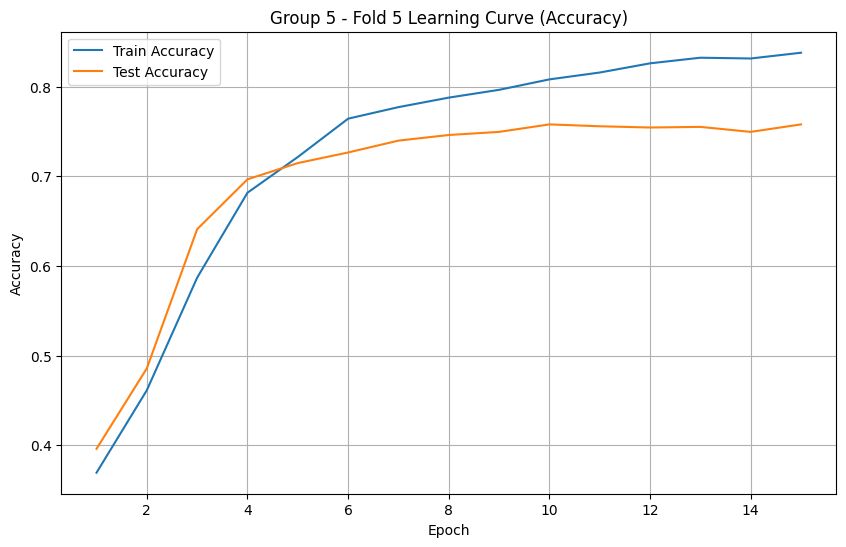

Confusion Matrix for Fold 1 is invalid or missing.


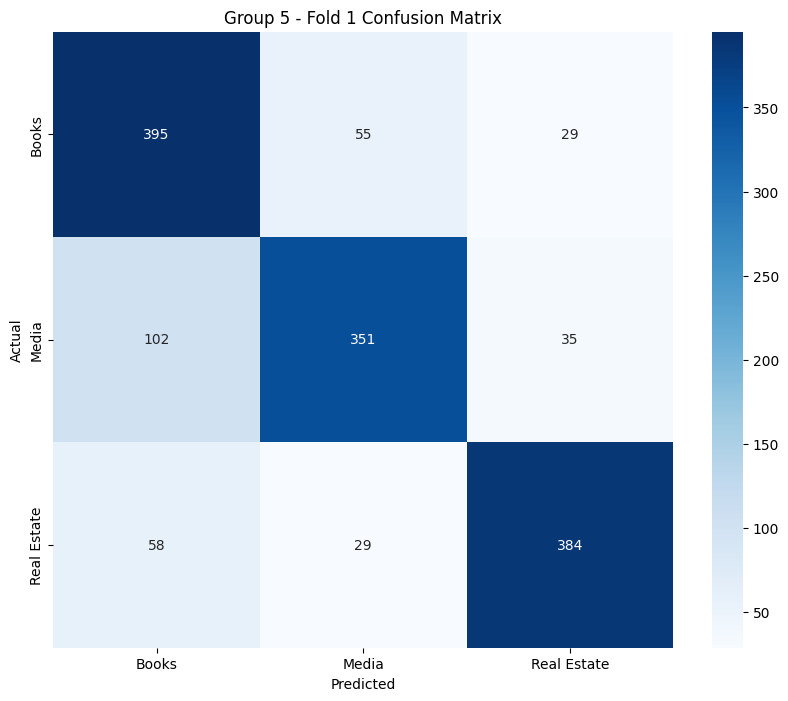

Confusion Matrix for Fold 2 is invalid or missing.


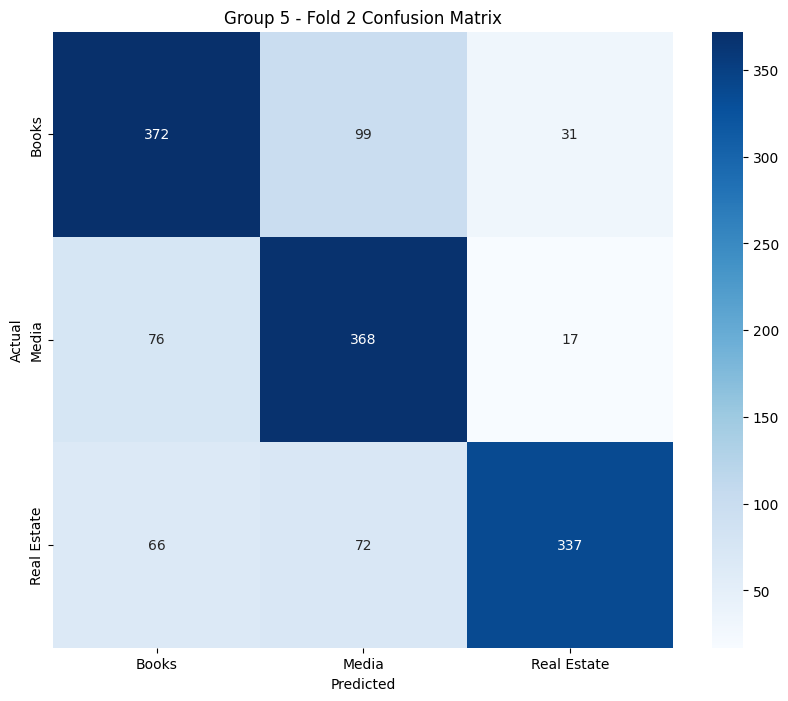

Confusion Matrix for Fold 3 is invalid or missing.


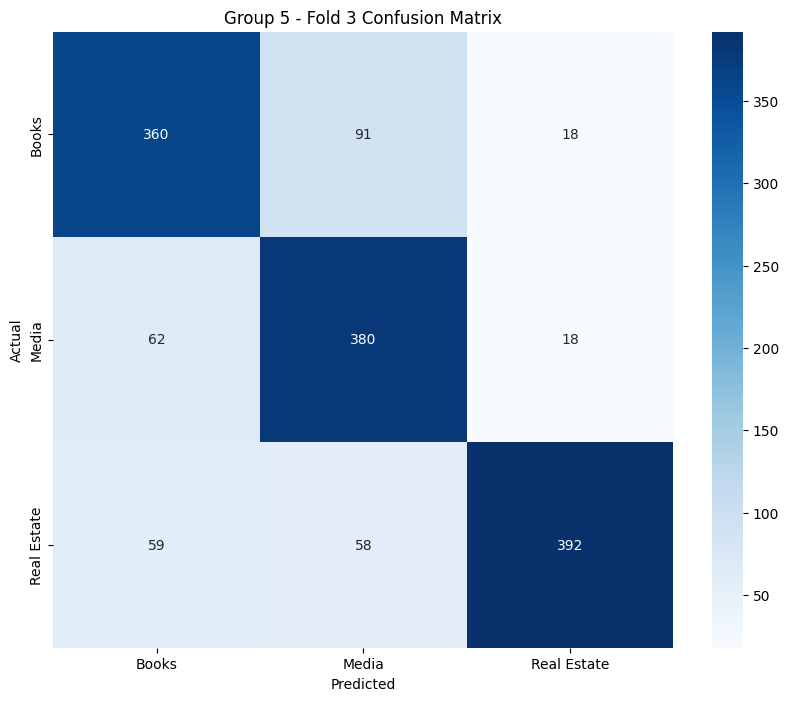

Confusion Matrix for Fold 4 is invalid or missing.


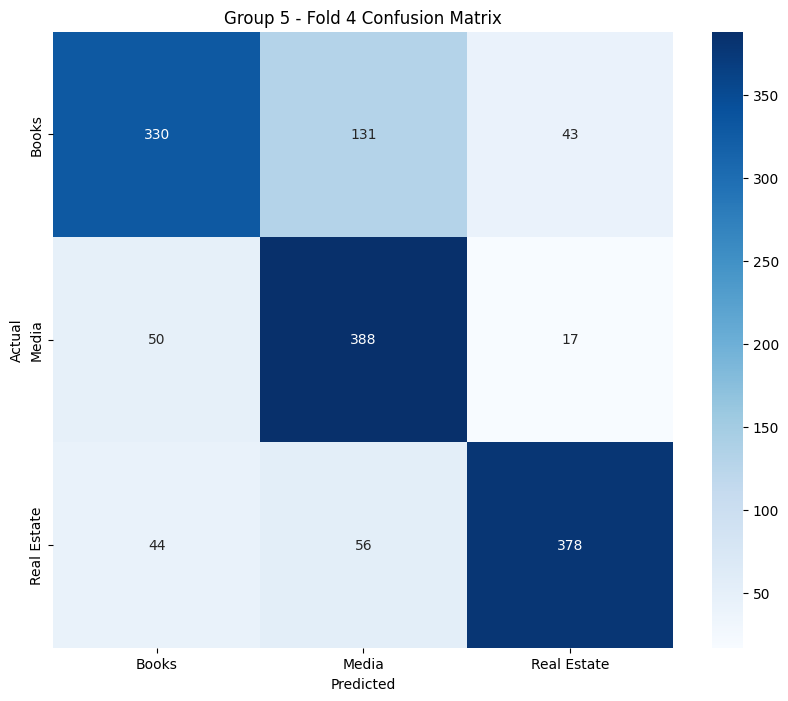

Confusion Matrix for Fold 5 is invalid or missing.


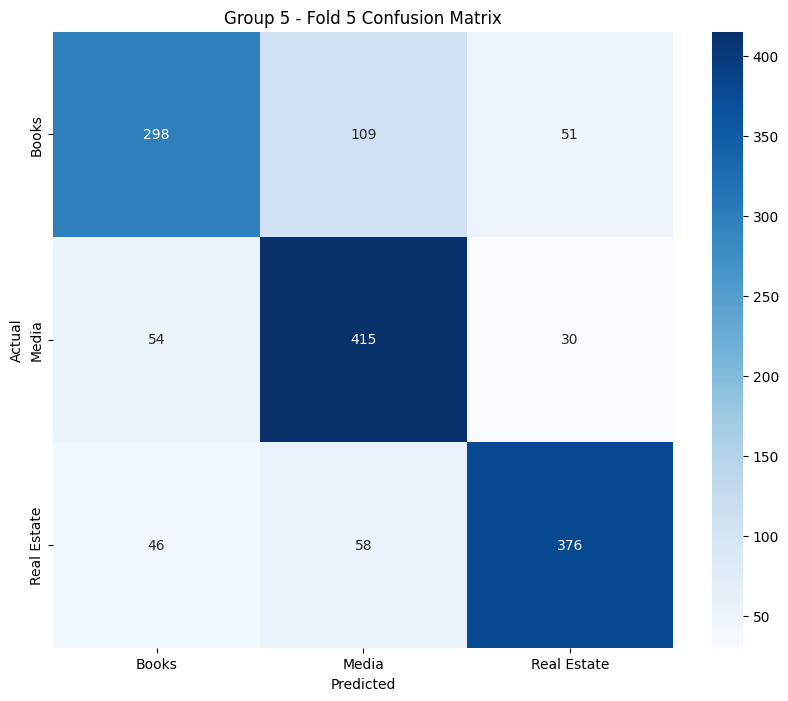


Group 6 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1350, Test Accuracy: 0.3354
epoch 1/15: train loss 1.0945, train acc 0.3706
                         test loss 1.0544, test acc 0.4437
epoch 5/15: train loss 0.5030, train acc 0.8145
                         test loss 0.5177, test acc 0.8042
epoch 10/15: train loss 0.3295, train acc 0.8861
                         test loss 0.4477, test acc 0.8444
epoch 15/15: train loss 0.2639, train acc 0.9095
                         test loss 0.5045, test acc 0.8389

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1028, Test Accuracy: 0.3444
epoch 1/15: train loss 1.0192, train acc 0.4693
                         test loss 0.8308, test acc 0.6375
epoch 5/15: train loss 0.4893, train acc 0.8183
                         test loss 0.4659, test acc 0.8181
epoch 10/15: train loss 0.3647, train acc 0.8715
                         test loss 0.4145, test acc 0.8431
epoch 15/15: train loss 0.3067, train acc 0.8979
                         t

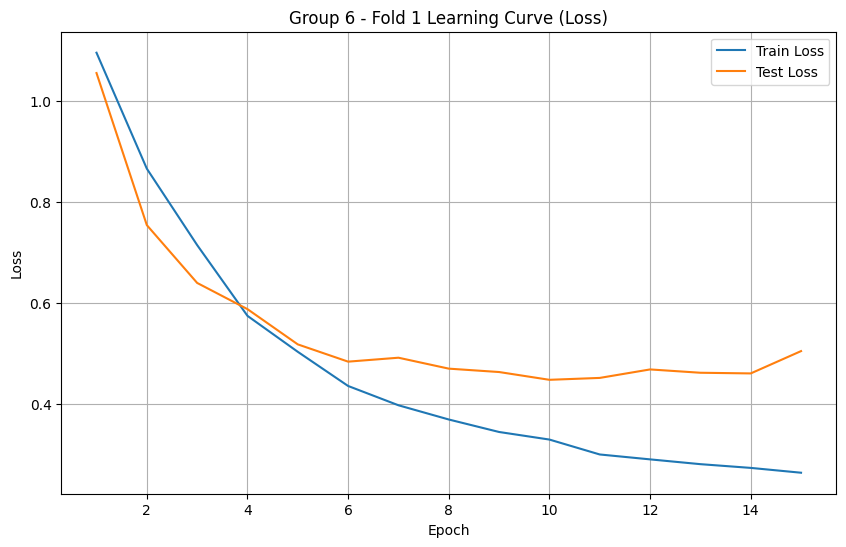

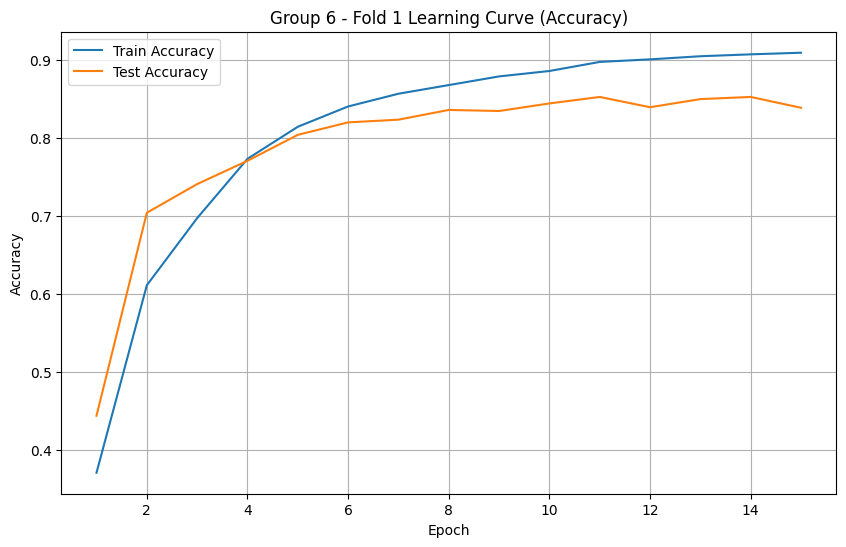

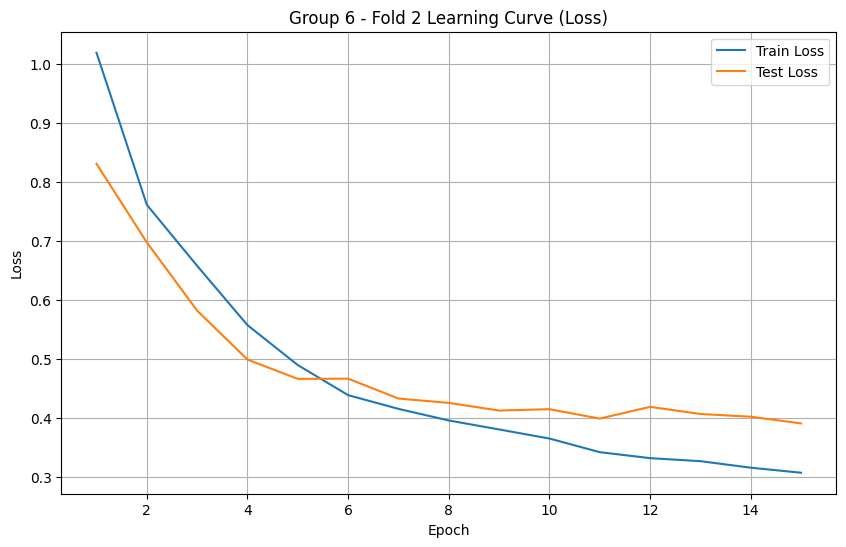

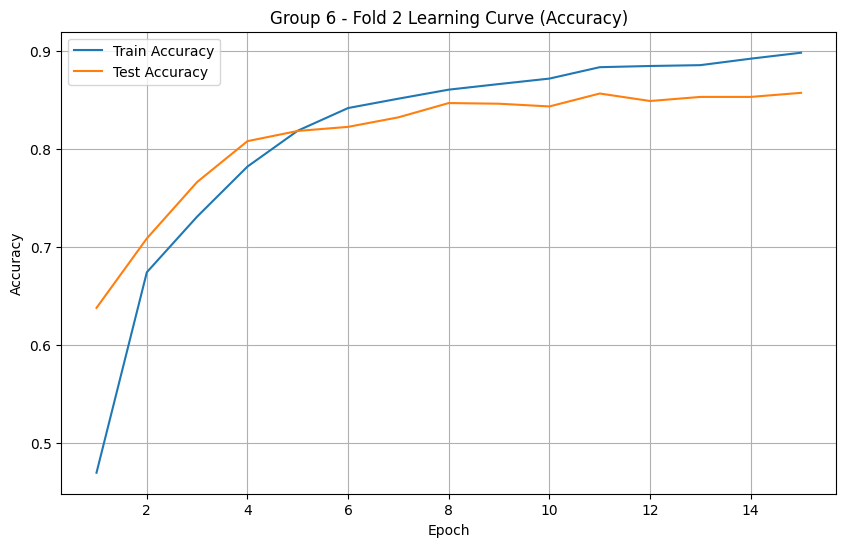

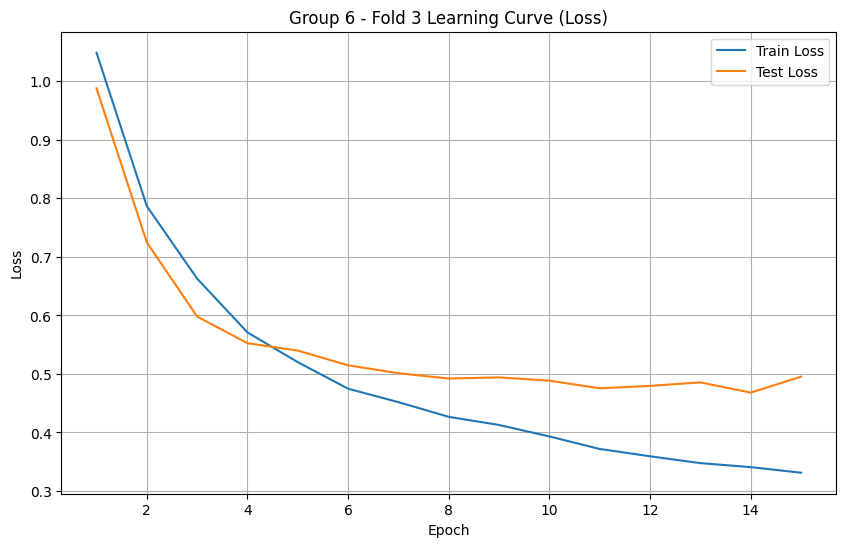

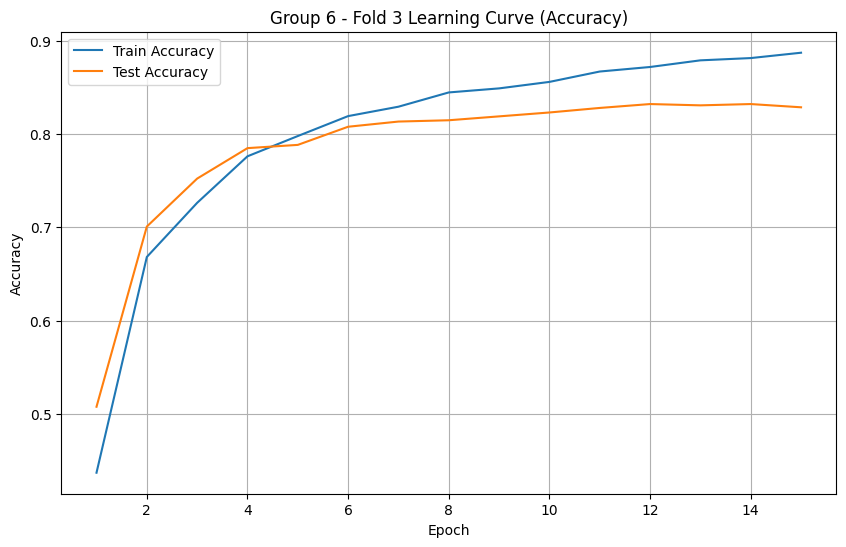

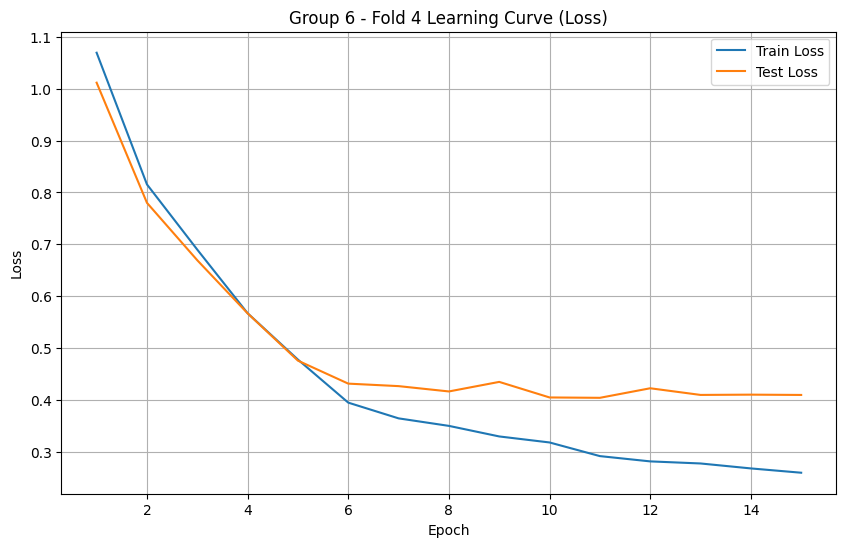

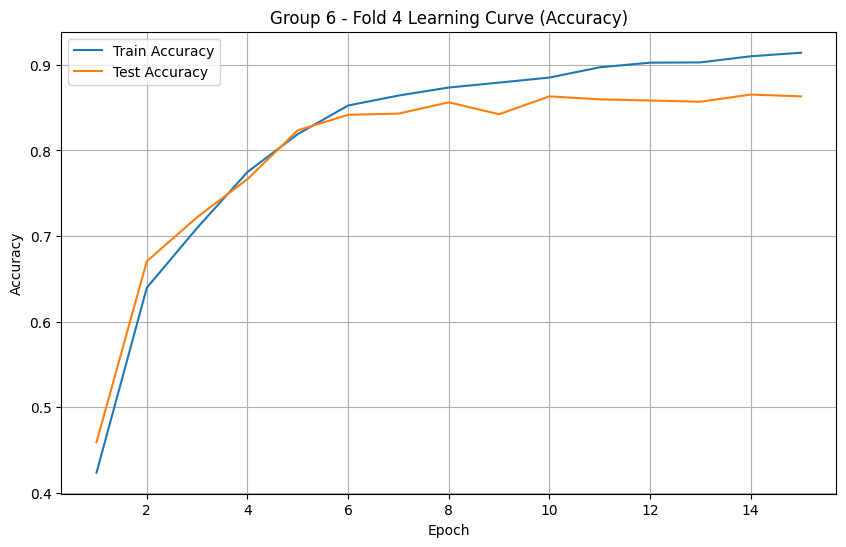

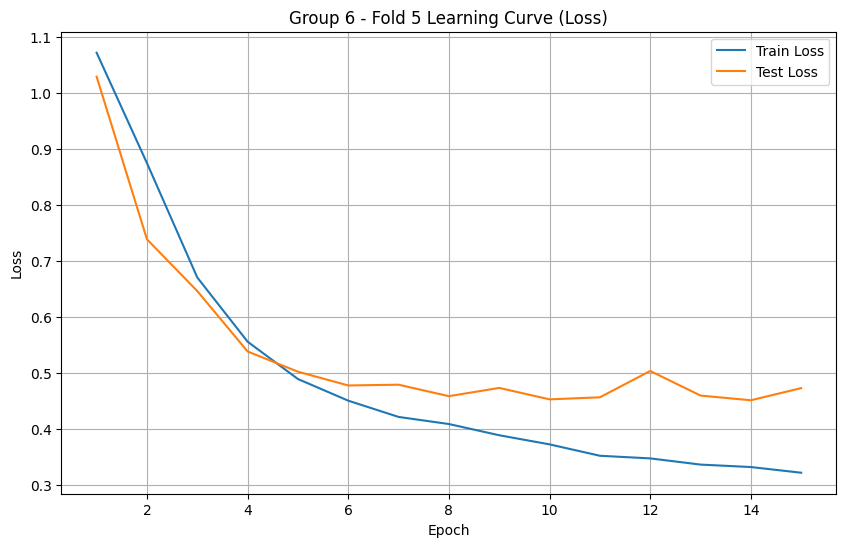

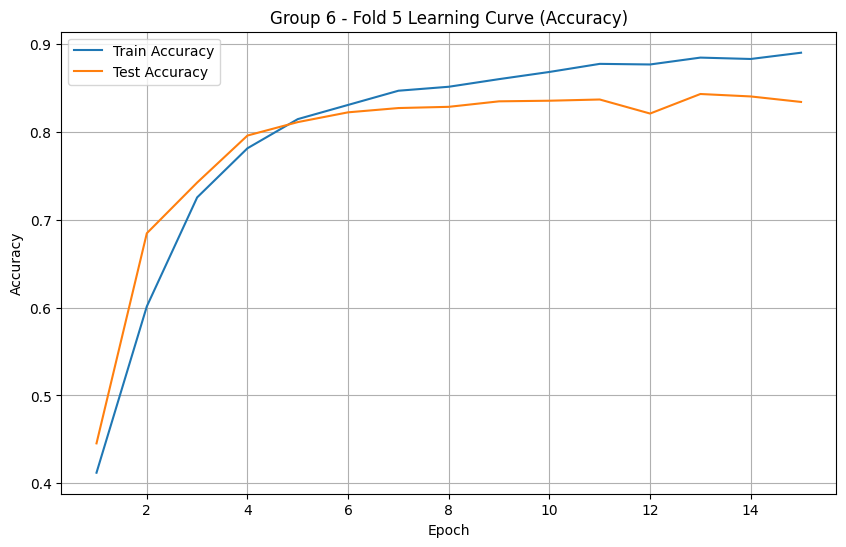

Confusion Matrix for Fold 1 is invalid or missing.


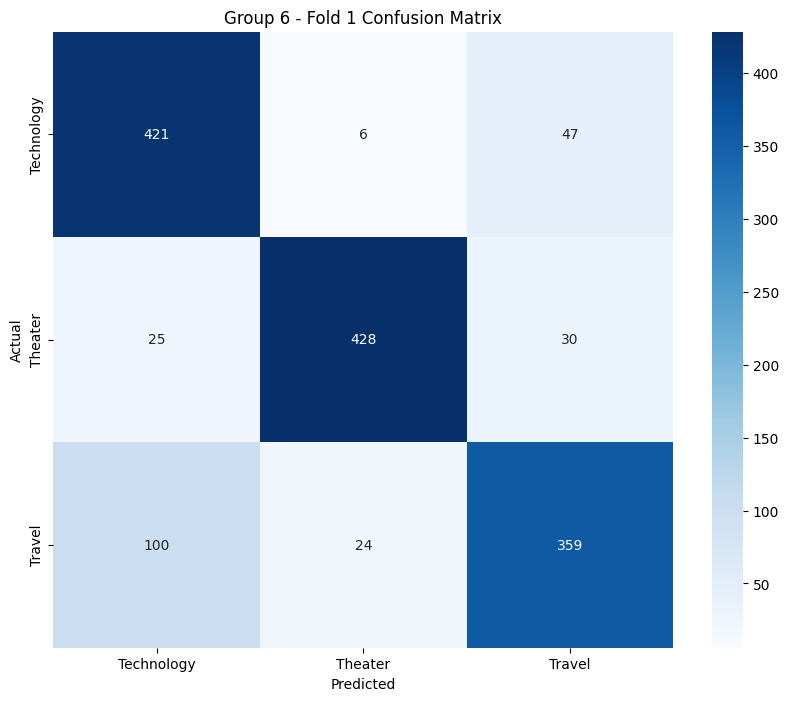

Confusion Matrix for Fold 2 is invalid or missing.


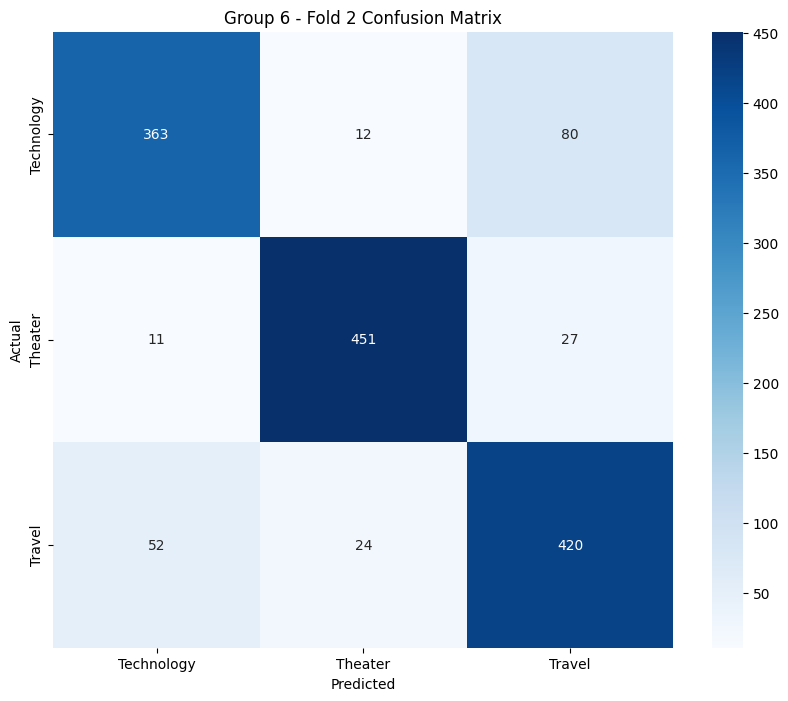

Confusion Matrix for Fold 3 is invalid or missing.


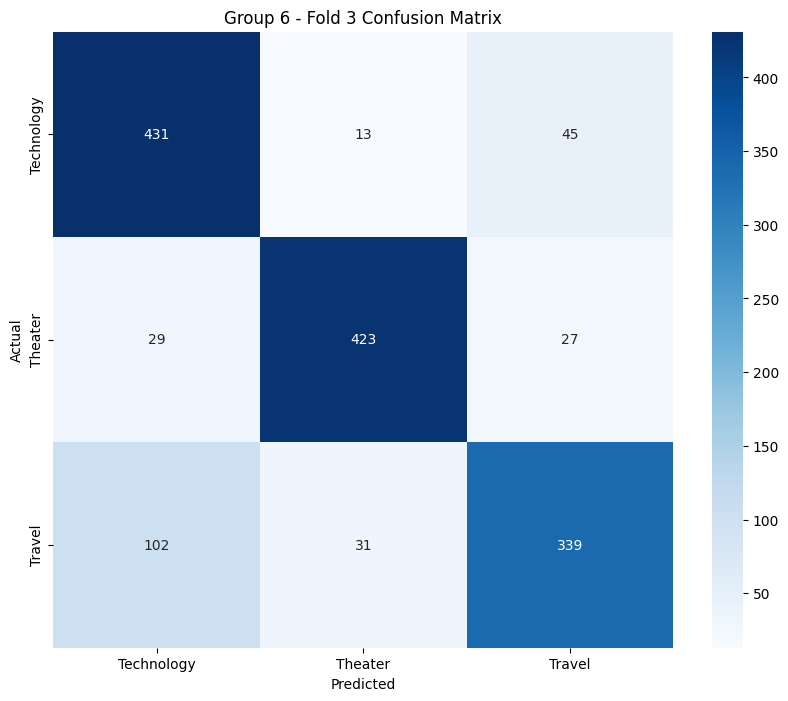

Confusion Matrix for Fold 4 is invalid or missing.


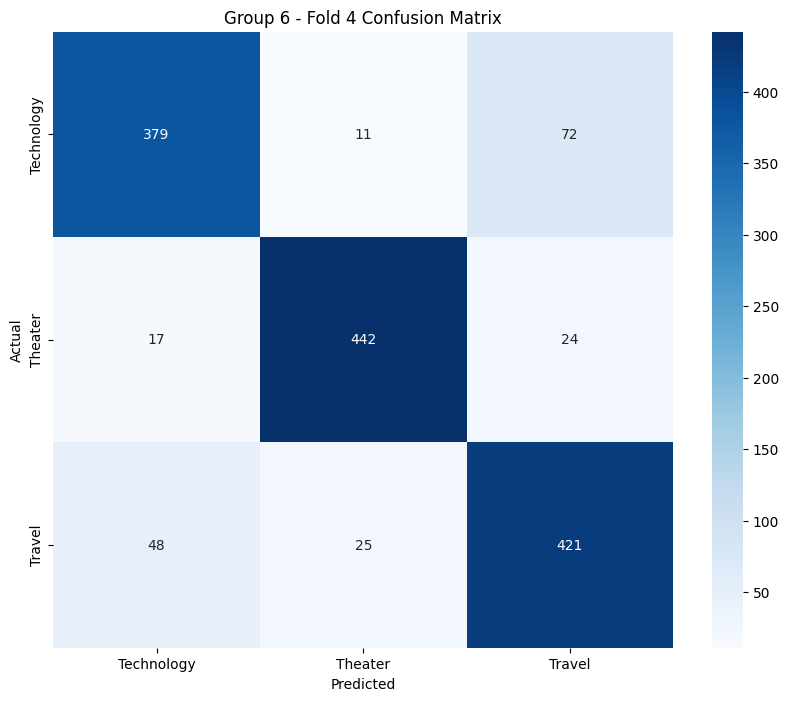

Confusion Matrix for Fold 5 is invalid or missing.


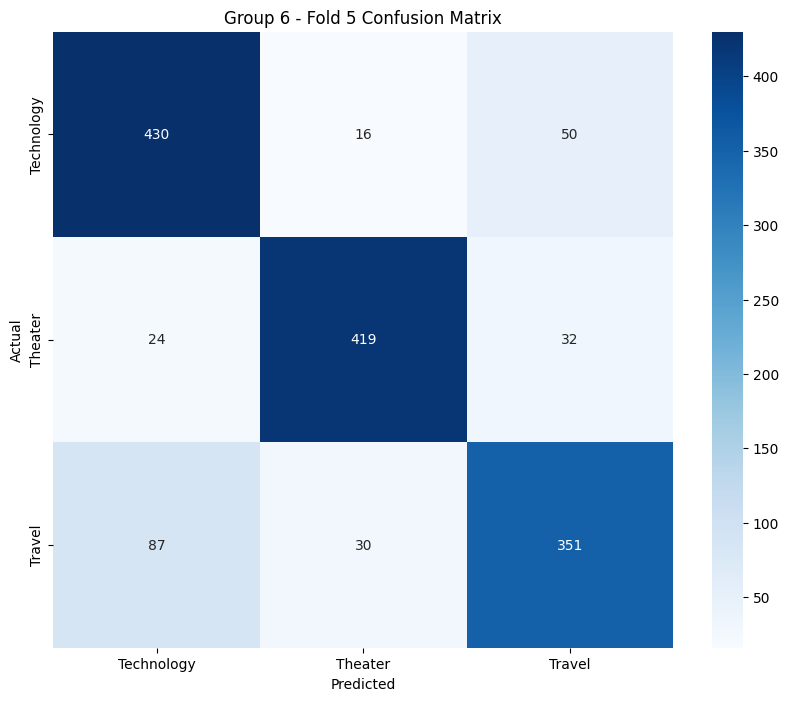

In [11]:
results = []
all_learning_curves = []



for idx, group_file in enumerate(output_paths, start=1):
    print(f"\nGroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, labels)
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []

    averaged_state_dict = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  Fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        # Perceiver 모델 초기화
        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        # CombinedModel 초기화
        combined_model = CombinedModel(
            vocab_size=tokenizer.vocab_size,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )

        # PackNet
        packnet_model = PackNet(combined_model)
        packnet_model.to(device)
        packnet_model.set_task(f"task_{idx}_{fold}")

        optimizer = optim.Adam(packnet_model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        # Pruning 이전 성능 평가
        print("Pruning 이전 성능:")
        initial_test_loss, initial_test_acc = eval_epoch(packnet_model, test_loader, criterion, device)
        print(f"  Test Loss: {initial_test_loss:.4f}, Test Accuracy: {initial_test_acc:.4f}")

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(packnet_model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(packnet_model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"epoch {epoch+1}/{EPOCHS}: train loss {train_loss:.4f}, train acc {train_acc:.4f}")
                print(f"                         test loss {test_loss:.4f}, test acc {test_acc:.4f}")

        # Fold 모델 상태 저장 및 평균 계산
        state_dict = packnet_model.state_dict()
        if averaged_state_dict is None:
            averaged_state_dict = {key: val.clone() for key, val in state_dict.items()}
        else:
            for key in averaged_state_dict:
                averaged_state_dict[key] += state_dict[key]

        
        # 결과 저장
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": None,
            "Classification Report": None
        })
        # learning curve
        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        # confusion matrix
        y_true, y_pred = [], []
        packnet_model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                labels_batch = batch['labels'].to(device)

                outputs = packnet_model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        if cm.ndim != 2:
            raise ValueError(f"Confusion Matrix must be 2D, but got shape {cm.shape}.")
        report = classification_report(y_true, y_pred, output_dict=True)

        fold_results.append({
        "Fold": fold,
        "Test Accuracy": test_acc,
        "Confusion Matrix": cm,
        "Classification Report": classification_report(y_true, y_pred, output_dict=True)
        })
    
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    # 평균 모델 저장
    checkpoint_path = f"/home/jisoo/Perceiver/Perceiver/checkpoints/group_{idx}_average_model.pth.tar"
    torch.save(averaged_state_dict, checkpoint_path)
    print(f"Average model checkpoint for Group {idx} saved at {checkpoint_path}")

    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

      
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="Train Loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="Test Loss")
        plt.title(f"Group {idx} - Fold {fold_idx} Learning Curve (Loss)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="Train Accuracy")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="Test Accuracy")
        plt.title(f"Group {idx} - Fold {fold_idx} Learning Curve (Accuracy)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        if cm is not None and cm.ndim == 2:
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=label_encoder.classes_,
                        yticklabels=label_encoder.classes_)
            plt.title(f"Group {idx} - Fold {fold_idx} Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
        else:
            print(f"Confusion Matrix for Fold {fold_idx} is invalid or missing.")

In [14]:
def prune_model(group_idx, checkpoint_dir, start_sparsity, end_sparsity, pruning_ratio, device):
    
    # 기존 모델 로딩
    checkpoint_path = f"{checkpoint_dir}/group_{group_idx}_average_model.pth.tar"
    print(f"Loading checkpoint for Group {group_idx} from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    num_classes = checkpoint.get('num_classes', checkpoint['model.perceiver.output_layer.weight'].size(0))

    perceiver = Perceiver(
        input_dim=128, 
        latent_dim=64,
        latent_size=64,
        num_classes=num_classes,
        num_blocks=4,
        self_attn_layers_per_block=1
    )

    combined_model = CombinedModel(
        vocab_size=tokenizer.vocab_size,
        embed_dim=128,
        perceiver_model=perceiver
    )

    packnet_model = PackNet(combined_model)
    model_state_dict = checkpoint

    # 일치하지 않는 키 필터링
    filtered_state_dict = {
        key: value
        for key, value in model_state_dict.items()
        if key in packnet_model.state_dict() and packnet_model.state_dict()[key].size() == value.size()
    }
    packnet_model.load_state_dict(filtered_state_dict, strict=False)
    packnet_model.to(device)
    packnet_model.set_task(f"group_{group_idx}_pruning")
    print("Model successfully loaded with matched parameters.")

    # 가중치 보고 pruning
    current_sparsity = start_sparsity
    while current_sparsity <= end_sparsity:
        print(f"Applying pruning with sparsity: {current_sparsity:.2f}")
        for name, module in packnet_model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                weights = module.weight.data.abs().flatten()
                threshold = torch.quantile(weights, current_sparsity)
                mask = module.weight.data.abs() >= threshold
                module.weight.data *= mask

                # 마스크 선택적으로 저장
                if not hasattr(module, 'mask'):
                    module.mask = mask

        current_sparsity += pruning_ratio

    print("Pruning completed.")

    # pruned model 저장
    pruned_checkpoint_path = f"{checkpoint_dir}/group_{group_idx}_pruned_model.pth.tar"
    torch.save({
        "model_state_dict": packnet_model.state_dict(),
        "num_classes": num_classes,  # Replace with actual number of classes
        "vocab_size": tokenizer.vocab_size
    }, pruned_checkpoint_path)
    print(f"Pruned model for Group {group_idx} saved at {pruned_checkpoint_path}.")

# pruning 파라미터
groups = [1, 2, 3, 4, 5, 6]  
checkpoint_dir = "/home/jisoo/Perceiver/Perceiver/checkpoints"
start_sparsity = 0.05
end_sparsity = 0.2
pruning_ratio = 0.05
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for group_idx in groups:
    prune_model(
        group_idx=group_idx,
        checkpoint_dir=checkpoint_dir,
        start_sparsity=start_sparsity,
        end_sparsity=end_sparsity,
        pruning_ratio=pruning_ratio,
        device=device
    )

Loading checkpoint for Group 1 from /home/jisoo/Perceiver/Perceiver/checkpoints/group_1_average_model.pth.tar...
Model successfully loaded with matched parameters.
Applying pruning with sparsity: 0.05
Applying pruning with sparsity: 0.10
Applying pruning with sparsity: 0.15
Applying pruning with sparsity: 0.20
Pruning completed.


/tmp/ipykernel_147342/4049929000.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 128 vs 0

In [17]:
def prune_model(group_idx, checkpoint_dir, start_sparsity, end_sparsity, pruning_ratio, device):
    
    # 기존 모델 로딩
    checkpoint_path = f"{checkpoint_dir}/group_{group_idx}_average_model.pth.tar"
    print(f"Loading checkpoint for Group {group_idx} from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    num_classes = checkpoint.get('num_classes', checkpoint['model.perceiver.output_layer.weight'].size(0))

    perceiver = Perceiver(
        input_dim=128, 
        latent_dim=64,
        latent_size=64,
        num_classes=num_classes,
        num_blocks=4,
        self_attn_layers_per_block=1
    )

    combined_model = CombinedModel(
        vocab_size=tokenizer.vocab_size,
        embed_dim=128,
        perceiver_model=perceiver
    )

    packnet_model = PackNet(combined_model)
    model_state_dict = checkpoint

    # 일치하지 않는 키 필터링
    filtered_state_dict = {
        key: value
        for key, value in model_state_dict.items()
        if key in packnet_model.state_dict() and packnet_model.state_dict()[key].size() == value.size()
    }
    packnet_model.load_state_dict(filtered_state_dict, strict=False)
    packnet_model.to(device)
    packnet_model.set_task(f"group_{group_idx}_pruning")
    print("Model successfully loaded with matched parameters.")

    # 가중치 보고 pruning
    current_sparsity = start_sparsity
    while current_sparsity <= end_sparsity:
        print(f"Applying pruning with sparsity: {current_sparsity:.2f}")
        for name, module in packnet_model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                weights = module.weight.data.abs().flatten()
                threshold = torch.quantile(weights, current_sparsity)
                mask = module.weight.data.abs() >= threshold
                module.weight.data *= mask

                # 마스크 선택적으로 저장
                if not hasattr(module, 'mask'):
                    module.mask = mask

        current_sparsity += pruning_ratio

    print("Pruning completed.")

    # pruned model 저장
    pruned_checkpoint_path = f"{checkpoint_dir}/group_{group_idx}_pruned_model.pth.tar"
    torch.save({
        "model_state_dict": packnet_model.state_dict(),
        "num_classes": num_classes,  # Replace with actual number of classes
        "vocab_size": tokenizer.vocab_size
    }, pruned_checkpoint_path)
    print(f"Pruned model for Group {group_idx} saved at {pruned_checkpoint_path}.")

# pruning 파라미터
groups = [1, 2, 3, 4, 5, 6]  
checkpoint_dir = "/home/jisoo/Perceiver/Perceiver/checkpoints"
start_sparsity = 0.05
end_sparsity = 0.2
pruning_ratio = 0.05
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for group_idx in groups:
    prune_model(
        group_idx=group_idx,
        checkpoint_dir=checkpoint_dir,
        start_sparsity=start_sparsity,
        end_sparsity=end_sparsity,
        pruning_ratio=pruning_ratio,
         device=device
    )

Loading checkpoint for Group 1 from /home/jisoo/Perceiver/Perceiver/checkpoints/group_1_average_model.pth.tar...
Model successfully loaded with matched parameters.
Applying pruning with sparsity: 0.05
Applying pruning with sparsity: 0.10
Applying pruning with sparsity: 0.15
Applying pruning with sparsity: 0.20
Pruning completed.


/tmp/ipykernel_147342/3824504956.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 128 vs 0

In [ ]:
def prepare_test_loader(group_idx, batch_size=32):
    
    group_file = output_paths[group_idx - 1]
    df = pd.read_csv(group_file)

   
    input_ids = tokenize_data(df)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    labels = torch.tensor(df['Label'].values)
    test_dataset = CustomDataset(input_ids, labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader, label_encoder

def load_pruned_model(group_idx, checkpoint_dir, device):
    
    checkpoint_path = f"{checkpoint_dir}/group_{group_idx}_pruned_model.pth.tar"
    print(f"Loading pruned model for Group {group_idx} from {checkpoint_path}...")

    # checkpoint 로드
    checkpoint = torch.load(checkpoint_path, map_location=device)
    num_classes = checkpoint.get('num_classes', 10)  # Use default if not in checkpoint

    # 모델 초기화
    perceiver = Perceiver(
        input_dim=128,  # Match embedding dimension
        latent_dim=64,
        latent_size=64,
        num_classes=num_classes,
        num_blocks=4,
        self_attn_layers_per_block=1
    )

    combined_model = CombinedModel(
        vocab_size=checkpoint.get('vocab_size', tokenizer.vocab_size),
        embed_dim=128,
        perceiver_model=perceiver
    )

    packnet_model = PackNet(combined_model)
    packnet_model.load_state_dict(checkpoint['model_state_dict'])
    packnet_model.to(device)
    packnet_model.set_task(f"group_{group_idx}_evaluation")
    print("Pruned model loaded successfully.")

    return packnet_model

In [ ]:
def evaluate_pruned_model(packnet_model, test_loader, criterion, device):
    packnet_model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = packnet_model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

checkpoint_dir = "/home/jisoo/Perceiver/Perceiver/checkpoints"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for group_idx in range(1, len(output_paths) + 1):
    # dataloader 불러오기
    test_loader, label_encoder = prepare_test_loader(group_idx, batch_size=32)

    pruned_model = load_pruned_model(group_idx, checkpoint_dir, device)
    criterion = nn.CrossEntropyLoss()

    # evaluate
    test_loss, test_accuracy = evaluate_pruned_model(pruned_model, test_loader, criterion, device)
    print(f"Group {group_idx}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
